In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Tuple, List
from multiprocessing import Pool
import pickle

from forward_models import RAIN_EXISTENCE_RATE, SOIL_VOID_SPACE_MM, SOIL_DEPTH_MM, generate_rain, hydrology_model, soil_organic_model, inorganic_nitrogen_model
from dp_solver import solve_dp, calculate_probabilities_of_violation, KernelMetadata

rng = np.random.default_rng(12345)

In [23]:
CONTROL_TIMESTEP_DAYS = 9
NUM_CONTROL_STEPS = 4
# corn prices are measured in USD / 56 lbs at 15.5% moisture (by mass)
CORN_PRICE_USD_PER_G_GRAIN = 4.80 / (1 - 0.155) / 25401.2
N_PRICE_USD_PER_G = 0.0011
N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 = 1200
NNI_TO_RELATIVE_YIELD_CORRELATION = 0.99
MAX_BIOMASS_G_DRY_MASS_PER_M2 = 3000

INORGANIC_N_MODEL_DT_DAYS = 1.0 / 24.0 * 2.0 / 6.0

# Derived using PorporatoCharacterization.py
INITIAL_LITTER_CARBON_GC_PER_M3 = 400.0
INITIAL_LITTER_NITROGEN_GN_PER_M3 = 22.0
INITIAL_MICROBIAL_CARBON_GC_PER_M3 = 130.0
INITIAL_HUMUS_CARBON_GC_PER_M3 = 5500.0

NUM_DAYS_TOTAL = CONTROL_TIMESTEP_DAYS * NUM_CONTROL_STEPS
LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER = 10
LEACHING_AVERAGE_WINDOW_DAYS = 3
assert LEACHING_AVERAGE_WINDOW_DAYS <= CONTROL_TIMESTEP_DAYS
LEACHING_VIOLATION_PENALTY_USD_PER_M2 = (N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN) * 1.0
FORECAST_LOOKAHEAD_DAYS = 3
PROBABILITY_OF_CLEAR_FORECAST = (1 - RAIN_EXISTENCE_RATE) ** FORECAST_LOOKAHEAD_DAYS
PROBABILITY_OF_CLEAR_FORECAST

0.405224

In [24]:
# N_c (g/kg DM) = 3.40 * (W (Mg DM / ha))^-0.37
# N_c (g/ha) = 3.40 * (W (Mg DM/ha)) ^ (1 - 0.37)
biomass_g_per_m2_to_critical_nitrogen_gN_per_m2 = np.vectorize(lambda w: 0.187 * (w ** 0.63))
day_to_biomass_g_per_m2 = np.vectorize(lambda day: day / NUM_DAYS_TOTAL * MAX_BIOMASS_G_DRY_MASS_PER_M2 + 0.001)
day_to_plant_N_demand_gN_per_m3_per_day = np.vectorize(lambda day: 0.02565 * np.exp(-0.00095 * day_to_biomass_g_per_m2(day)) * MAX_BIOMASS_G_DRY_MASS_PER_M2 / NUM_DAYS_TOTAL / (SOIL_DEPTH_MM / 1000.)) #MAX_BIOMASS_G_DRY_MASS_PER_M2 / NUM_DAYS_TOTAL is dW/dt

Text(0, 0.5, 'N demand (gN/m^3/day)')

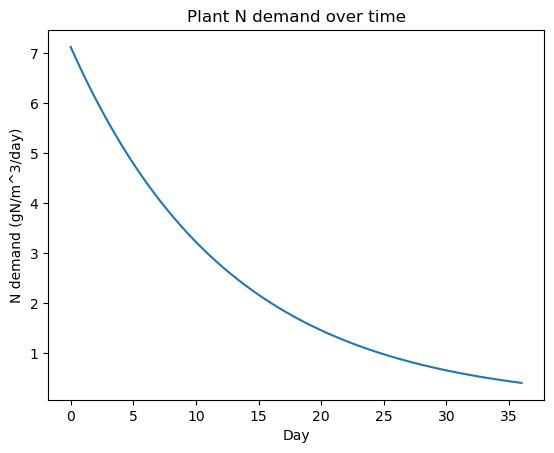

In [25]:
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, 100), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_DAYS_TOTAL, 100)))
plt.title("Plant N demand over time")
plt.xlabel("Day")
plt.ylabel("N demand (gN/m^3/day)")

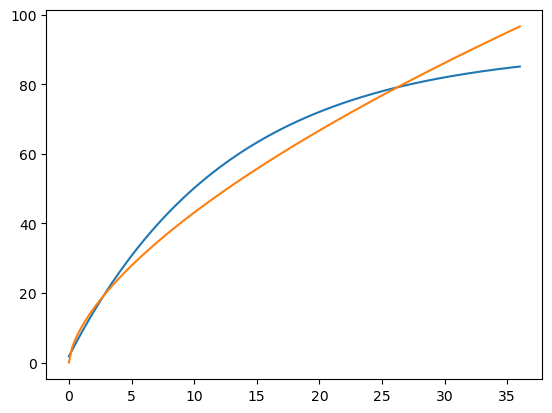

In [26]:
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, NUM_DAYS_TOTAL*4), np.cumsum(day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_DAYS_TOTAL, NUM_DAYS_TOTAL * 4)) / 4.0 ))
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, NUM_DAYS_TOTAL*4), biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(np.linspace(0, NUM_DAYS_TOTAL, NUM_DAYS_TOTAL*4))) / (SOIL_DEPTH_MM / 1000.))

In [5]:
print("N sufficient corn yield, in USD/m^2:", N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN)

N sufficient corn yield, in USD/m^2: 0.26835614251835654


# Inorganic Nitrogen Model

In [27]:
def nitrogen_deficit_cost(plant_total_N_gN_per_m3: npt.NDArray[np.float64], initial_day: float, dt_days: float = 1.0):
    time_days = np.linspace(initial_day, initial_day + len(plant_total_N_gN_per_m3) * dt_days, len(plant_total_N_gN_per_m3))
    plant_biomass_g_dry_mass_per_m2 = day_to_biomass_g_per_m2(time_days)
    critical_N_gN_per_m3 = biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(plant_biomass_g_dry_mass_per_m2) / (SOIL_DEPTH_MM / 1000.)
    NNI = np.clip(plant_total_N_gN_per_m3 / critical_N_gN_per_m3, a_min=0.0, a_max=1.0)

    decrease_to_full_season_NNI = (1.0 - np.average(NNI)) / NUM_CONTROL_STEPS
    return decrease_to_full_season_NNI * NNI_TO_RELATIVE_YIELD_CORRELATION * N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN

def leaching_limit_violated(leakage_rate_mm_per_day: npt.NDArray[np.float64], ammonium_leaching_gN_per_m3_per_day: npt.NDArray[np.float64], nitrate_leaching_gN_per_m3_per_day: npt.NDArray[np.float64], inorganic_n_model_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> bool:
    assert ammonium_leaching_gN_per_m3_per_day.shape == nitrate_leaching_gN_per_m3_per_day.shape
    for i in range(0, NUM_DAYS_TOTAL, LEACHING_AVERAGE_WINDOW_DAYS):
        total_leakage_L_per_m3 = np.sum(leakage_rate_mm_per_day[i:(i+LEACHING_AVERAGE_WINDOW_DAYS)])
        inorganic_n_model_lower_limit = int(i / inorganic_n_model_dt_days)
        inorganic_n_model_upper_limit = int((i + LEACHING_AVERAGE_WINDOW_DAYS) / inorganic_n_model_dt_days)
        if total_leakage_L_per_m3 > 0 and (np.sum(ammonium_leaching_gN_per_m3_per_day[inorganic_n_model_lower_limit:inorganic_n_model_upper_limit]) + np.sum(nitrate_leaching_gN_per_m3_per_day[inorganic_n_model_lower_limit:inorganic_n_model_upper_limit])) * inorganic_n_model_dt_days / total_leakage_L_per_m3 > (LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER / 1000.):
            return True
    return False

In [28]:
def simulate_from_rain_through_SOM(rain_quantity_mm: npt.NDArray, initial_soil_moisture: float, initial_litter_carbon_gC_per_m3: float = INITIAL_LITTER_CARBON_GC_PER_M3, initial_litter_nitrogen_gN_per_m3: float = INITIAL_LITTER_NITROGEN_GN_PER_M3, initial_microbial_carbon_gC_per_m3: float = INITIAL_MICROBIAL_CARBON_GC_PER_M3, initial_humus_carbon_gC_per_m3: float = INITIAL_HUMUS_CARBON_GC_PER_M3) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    num_days = len(rain_quantity_mm)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, _ = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(num_days), np.zeros(num_days))
    return leakage_rate_mm_per_day, transpiration_rate_mm_per_day, soil_moisture, net_flux_to_mineralized_nitrogen_g_per_m3_per_day, biomass_carbon_g_per_m3

def simulate_from_SOM(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_day: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], inorganic_n_model_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> Tuple[float, float, float, npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, initial_day, leakage_mm_per_day, transpiration_mm_per_day, soil_moisture, net_flux_to_mineral_nitrogen_gN_per_m3_per_day, microbial_carbon_gC_per_m3, day_to_plant_N_demand_gN_per_m3_per_day, output_dt_days=inorganic_n_model_dt_days)

    plant_uptake_gN_per_m3_per_day = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
    plant_cumulative_N_uptake_gN_per_m3 = np.cumsum(plant_uptake_gN_per_m3_per_day * inorganic_n_model_dt_days)

    return float(soil_moisture[-1]), ammonium_nitrogen_g_per_m3[-1], nitrate_nitrogen_g_per_m3[-1], plant_cumulative_N_uptake_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day

def simulate_all(num_days: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = INITIAL_LITTER_CARBON_GC_PER_M3, initial_litter_nitrogen_gN_per_m3: float = INITIAL_LITTER_NITROGEN_GN_PER_M3, initial_microbial_carbon_gC_per_m3: float = INITIAL_MICROBIAL_CARBON_GC_PER_M3, initial_humus_carbon_gC_per_m3: float = INITIAL_HUMUS_CARBON_GC_PER_M3):
    rain_quantity_mm = generate_rain(num_days)
    hydrology_and_SOM_results = simulate_from_rain_through_SOM(rain_quantity_mm, initial_soil_moisture, initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3)
    return simulate_from_SOM(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, *hydrology_and_SOM_results)


# Transition Probabilities

We have 3 states and two inputs, but we treat the inputs as instantaneous modifications of the state for computational efficiency. The states are ammonium (gN/m^3), nitrate (gN/m^3), and soil moisture (unitless, \[0, 1\]). All are non-negative quantities with a floor of zero.

We select maximum ammonium and nitrate of 28 gN/m^3, equivalent to about 200 lbs/acre of N. We select maximum soil moisture of 0.8, as above that our hydrology model gives nonsensical values.

We select a grid size of 1.0 for the nitrogens and 0.05 for soil moisture.

In [29]:
MAX_AMMONIUM = 8.4 / (SOIL_DEPTH_MM / 1000)
MAX_NITRATE = 33.63 / (SOIL_DEPTH_MM / 1000)
AMMONIUM_NUM_STEPS = 10
NITRATE_NUM_STEPS = 25
AMMONIUM_GRID_SIZE = MAX_AMMONIUM / AMMONIUM_NUM_STEPS
NITRATE_GRID_SIZE = MAX_NITRATE / NITRATE_NUM_STEPS

MAX_MOISTURE = 0.8
MOISTURE_GRID_SIZE = 0.05
MOISTURE_NUM_STEPS = int(MAX_MOISTURE / MOISTURE_GRID_SIZE)

MAX_ACCUMULATED_N = 100
ACCUMULATED_N_GRID_SIZE = 2
ACCUMULATED_N_NUM_STEPS = int(MAX_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)
MAX_SINGLE_STEP_ACCUMULATED_N = 100
SINGLE_STEP_ACCUMULATED_N_NUM_STEPS = int(MAX_SINGLE_STEP_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)

NUM_TRIALS_PER_INITIAL_CONDITION = 120
# print("Max ammonium/nitrate value: " + str(AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))))
# print("Max single-step fertilizer cost (USD/m^2):", (AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))) * 2 * N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.))
print("Max single-step fertilizer cost (USD/m^2):", (MAX_AMMONIUM + MAX_NITRATE) * N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.))

Max single-step fertilizer cost (USD/m^2): 0.046233


In [30]:
def values_to_indices(moisture: float, ammonium: float, nitrate: float) -> Tuple[int, int, int]:
    # ammonium_idx = np.clip(math.ceil(math.log(ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)), a_min=0, a_max=AMMONIUM_NUM_STEPS - 1)
    # nitrate_idx = np.clip(math.ceil(math.log(nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)), a_min=0, a_max = NITRATE_NUM_STEPS - 1)
    ammonium_idx = min(AMMONIUM_NUM_STEPS - 1, int(ammonium / AMMONIUM_GRID_SIZE))
    nitrate_idx = min(NITRATE_NUM_STEPS - 1, int(nitrate / NITRATE_GRID_SIZE))
    moisture_idx = min(MOISTURE_NUM_STEPS - 1, int(moisture / MOISTURE_GRID_SIZE))
    return moisture_idx, ammonium_idx, nitrate_idx

def indices_to_values(day_idx: int, moisture_idx: int, ammonium_idx: int, nitrate_idx: int) -> Tuple[float, float, float, float]:
    # if ammonium_idx == 0:
    #     ammonium = AMMONIUM_MINIMUM_CELL / 2.0
    # else:
    #     ammonium = AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (ammonium_idx - 0.5))
    # if nitrate_idx == 0:
    #     nitrate = NITRATE_MINIMUM_CELL / 2.0
    # else:
    #     nitrate = NITRATE_MINIMUM_CELL * (NITRATE_SCALE_FACTOR ** (nitrate_idx - 0.5))
    initial_day = float(day_idx * CONTROL_TIMESTEP_DAYS)
    moisture = MOISTURE_GRID_SIZE / 2.0 + MOISTURE_GRID_SIZE * moisture_idx
    ammonium = AMMONIUM_GRID_SIZE * ammonium_idx
    nitrate = NITRATE_GRID_SIZE * nitrate_idx
    return initial_day, moisture, ammonium, nitrate

def accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

def accumulated_N_index_to_value(accumulated_N_idx: int) -> float:
    return ACCUMULATED_N_GRID_SIZE / 2.0 + ACCUMULATED_N_GRID_SIZE * accumulated_N_idx

def single_step_accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(SINGLE_STEP_ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

In [11]:
rainfalls = {"early_rain": [], "no_early_rain": []}
for forecast in ["early_rain", "no_early_rain"]:
    i = 0
    while i < NUM_TRIALS_PER_INITIAL_CONDITION:
        candidate_rain = generate_rain(CONTROL_TIMESTEP_DAYS)
        if (any(candidate_rain[:FORECAST_LOOKAHEAD_DAYS] > 0) and forecast == "early_rain") or ((not any(candidate_rain[:FORECAST_LOOKAHEAD_DAYS] > 0)) and forecast == "no_early_rain"):
            rainfalls[forecast].append(candidate_rain)
            i += 1

SOM_and_hydrology_per_moisture = []
for moisture_idx_for_hydrology in range(MOISTURE_NUM_STEPS):
    initial_moisture_for_hydrology = indices_to_values(0, moisture_idx_for_hydrology, 0, 0)[1]
    trial_results = {"early_rain": [], "no_early_rain": []}
    for forecast in ["early_rain", "no_early_rain"]:
        for rainfall in rainfalls[forecast]:
            result = simulate_from_rain_through_SOM(rainfall, initial_moisture_for_hydrology)
            trial_results[forecast].append(result)
    SOM_and_hydrology_per_moisture.append(trial_results)

In [10]:
def transition_probabilities_from_initial_condition(inputs_tuple: Tuple[int, int, int, int, int]) -> Tuple[int, int, int, int, int, npt.NDArray[np.uint8], npt.NDArray[np.float64]]:
    initial_day_idx, initial_forecast_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx = inputs_tuple
    initial_day, initial_moisture, initial_ammonium, initial_nitrate  = indices_to_values(initial_day_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx)
    initial_forecast = "early_rain" if initial_forecast_idx == 1 else "no_early_rain"
    end_state_counts = np.zeros([2, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)
    costs = np.zeros([ACCUMULATED_N_NUM_STEPS], np.float64)
    for SOM_and_hydrology_results in SOM_and_hydrology_per_moisture[initial_moisture_idx][initial_forecast]:
        end_moisture, end_ammonium, end_nitrate, plant_cumulative_uptake_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day = simulate_from_SOM(initial_ammonium, initial_nitrate, initial_day, *SOM_and_hydrology_results, inorganic_n_model_dt_days=INORGANIC_N_MODEL_DT_DAYS)
        N_uptake_over_period_gN_per_m3 = plant_cumulative_uptake_gN_per_m3[-1]
        is_leaching_limit_violated = int(leaching_limit_violated(SOM_and_hydrology_results[0], ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day))
        end_state_counts[is_leaching_limit_violated, single_step_accumulated_N_value_to_index(N_uptake_over_period_gN_per_m3), *values_to_indices(end_moisture, end_ammonium, end_nitrate)] += 1
        for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
            costs[initial_accumulated_N_index] += nitrogen_deficit_cost(plant_cumulative_uptake_gN_per_m3 + accumulated_N_index_to_value(initial_accumulated_N_index), initial_day, dt_days=INORGANIC_N_MODEL_DT_DAYS)
    costs /= len(SOM_and_hydrology_per_moisture[initial_moisture_idx][initial_forecast])
    return initial_day_idx, initial_forecast_idx, initial_moisture_idx, initial_ammonium_idx, initial_nitrate_idx, end_state_counts, costs

class InitialConditionIterator:
    def __iter__(self):
        self.initial_day_idx = 0
        self.initial_forecast_idx = 0
        self.moisture_idx = 0
        self.ammonium_idx = 0
        self.nitrate_idx = 0
        return self

    def __next__(self):
        if self.initial_day_idx >= NUM_CONTROL_STEPS:
            raise StopIteration
        out = (self.initial_day_idx, self.initial_forecast_idx, self.moisture_idx, self.ammonium_idx, self.nitrate_idx)
        self.nitrate_idx += 1
        if self.nitrate_idx >= NITRATE_NUM_STEPS:
            self.nitrate_idx = 0
            self.ammonium_idx += 1
            if self.ammonium_idx >= AMMONIUM_NUM_STEPS:
                self.ammonium_idx = 0
                self.moisture_idx += 1
                if self.moisture_idx >= MOISTURE_NUM_STEPS:
                    self.moisture_idx = 0
                    self.initial_forecast_idx += 1
                    if self.initial_forecast_idx >= 2:
                        self.initial_forecast_idx = 0
                        self.initial_day_idx += 1
        return out

In [13]:
# initial time, initial weather forecast, initial moisture, initial ammonium, initial nitrate, resulting leaching violation, resulting N accumulation, resulting moisture, resulting ammonium, resulting nitrate
transition_counts = np.zeros([NUM_CONTROL_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, 2, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint8)
expected_plant_N_deficit_cost_USD = np.zeros([NUM_CONTROL_STEPS, ACCUMULATED_N_NUM_STEPS, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)

with Pool(processes = 12) as pool: # parallel processing
    for transition_probability_results in pool.imap_unordered(transition_probabilities_from_initial_condition, iter(InitialConditionIterator())):
        transition_initial_day_idx, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx, transition_end_state_counts, costs_by_accumulated_N = transition_probability_results
        # No need to store the transition kernel for the final step, we don't need the terminal state
        transition_counts[transition_initial_day_idx, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx] = transition_end_state_counts
        expected_plant_N_deficit_cost_USD[transition_initial_day_idx, :, transition_initial_forecast_idx, transition_initial_moisture_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx] = costs_by_accumulated_N

In [14]:
for i in range(NUM_CONTROL_STEPS):
    for j in range(2):
        for k in range(MOISTURE_NUM_STEPS):
            for l in range(AMMONIUM_NUM_STEPS):
                for m in range(NITRATE_NUM_STEPS):
                    if np.sum(transition_counts[i, j, k, l, m]) != NUM_TRIALS_PER_INITIAL_CONDITION:
                        print("Failed sanity check at [{}, {}, {}, {}]".format(i, j, k, l))
                        break

In [31]:
def display_moisture_slice(array_slice: npt.NDArray[np.float64], title: str, from_nitrate: float = None, from_ammonium: float = None, to_nitrate: float = None, to_ammonium: float = None, fig: plt.Figure = None, ax: plt.Axes = None, colorbar=True, **imshow_kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower', **imshow_kwargs)
    if colorbar:
        fig.colorbar(img)

    if from_nitrate is not None and from_ammonium is not None:
        ax.plot([from_nitrate / NITRATE_GRID_SIZE], [from_ammonium / AMMONIUM_GRID_SIZE], 'o', color="pink")
        if to_nitrate is not None and to_ammonium is not None:
            ax.plot([to_nitrate / NITRATE_GRID_SIZE], [to_ammonium / AMMONIUM_GRID_SIZE], 'o', color="pink")
            # ax.arrow(from_nitrate, from_ammonium, to_nitrate - from_nitrate, to_ammonium - from_ammonium)
            ax.annotate("", xytext=(from_nitrate / NITRATE_GRID_SIZE, from_ammonium / AMMONIUM_GRID_SIZE), xy=(to_nitrate / NITRATE_GRID_SIZE, to_ammonium / AMMONIUM_GRID_SIZE), textcoords="data", arrowprops=dict(arrowstyle="->", color="pink"), annotation_clip=False)
    #     x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
    #     y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
    #     ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    ammonium_ticks = list(np.linspace(0, AMMONIUM_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    ammonium_labels = []
    for tick in ammonium_ticks:
        ammonium_labels.append(str(round(indices_to_values(0, 0, tick, 0)[2], 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(indices_to_values(0, 0, 0, tick)[3], 3)))

    ax.set_yticks(ammonium_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(ammonium_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Ammonium level (gN/m^3)")
    ax.set_xlabel("Nitrate level (gN/m^3)")
    ax.set_title(title)
    return img

def display_ammonium_slice(array_slice: npt.NDArray[np.float64], title: str, from_nitrate: float = None, from_moisture: float = None, to_nitrate: float = None, to_moisture: float = None, fig: plt.Figure = None, ax: plt.Axes = None, colorbar=True, **imshow_kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower', **imshow_kwargs)
    if colorbar:
        fig.colorbar(img)

    if from_nitrate is not None and from_moisture is not None:
        ax.plot([from_nitrate / NITRATE_GRID_SIZE], [from_moisture / MOISTURE_GRID_SIZE], 'o', color="pink")
        if to_nitrate is not None and from_moisture is not None:
            ax.plot([to_nitrate / NITRATE_GRID_SIZE], [from_moisture / MOISTURE_GRID_SIZE], 'o', color="pink")
            # ax.arrow(from_nitrate, from_ammonium, to_nitrate - from_nitrate, to_ammonium - from_ammonium)
            ax.annotate("", xytext=(from_nitrate / NITRATE_GRID_SIZE, from_moisture / AMMONIUM_GRID_SIZE), xy=(to_nitrate / NITRATE_GRID_SIZE, from_moisture / MOISTURE_GRID_SIZE), textcoords="data", arrowprops=dict(arrowstyle="->", color="pink"), annotation_clip=False)
    #     x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
    #     y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
    #     ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    moisture_ticks = list(np.linspace(0, MOISTURE_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    moisture_labels = []
    for tick in moisture_ticks:
        moisture_labels.append(str(round(indices_to_values(0, tick, 0, 0)[1], 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(indices_to_values(0, 0, 0, tick)[3], 3)))

    ax.set_yticks(moisture_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(moisture_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Moisture")
    ax.set_xlabel("Nitrate level (gN/m^3)")
    ax.set_title(title)
    return img

def moisture_idx_to_string(moisture_index: int):
    return str(round(indices_to_values(0, moisture_index, 0, 0)[1], 3))

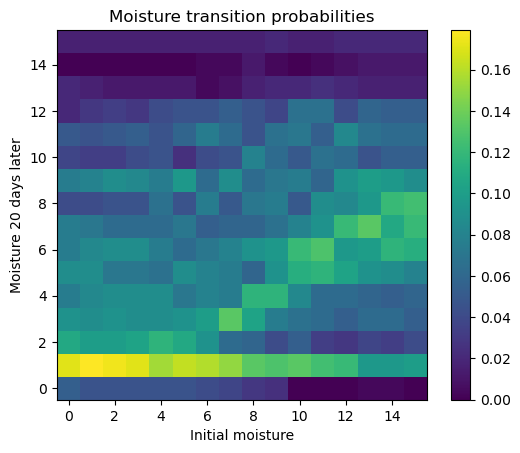

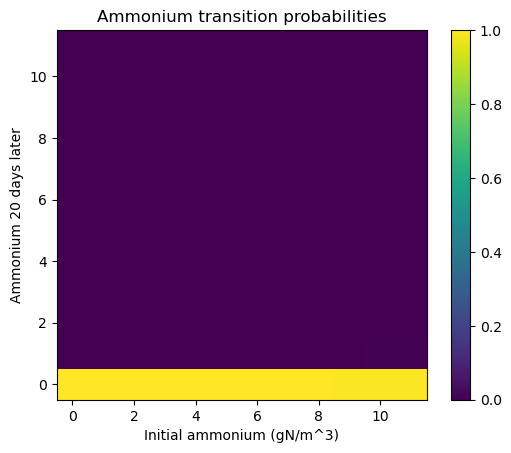

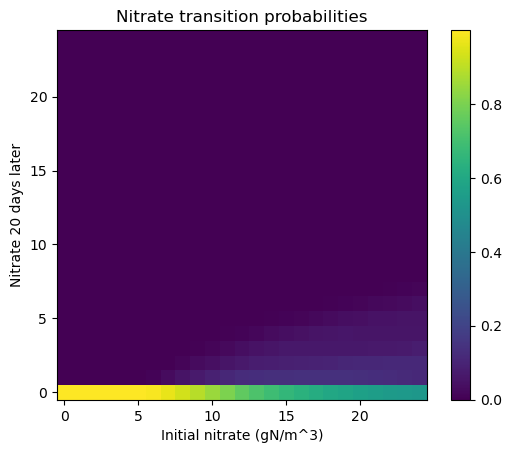

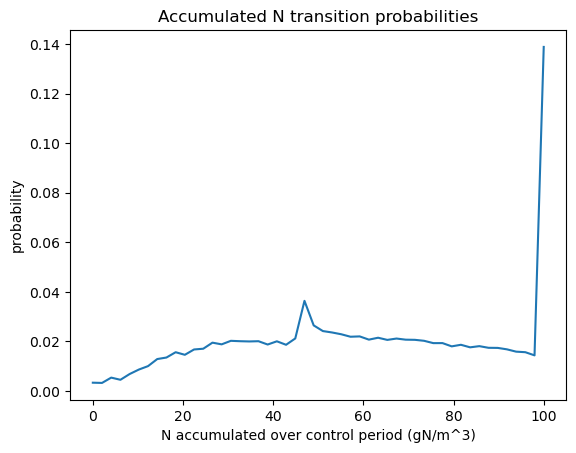

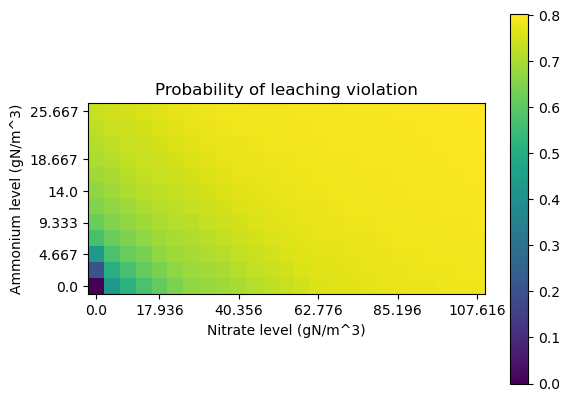

In [16]:
plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 3, 4, 5, 6, 8, 9), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Moisture transition probabilities")
plt.xlabel("Initial moisture")
plt.ylabel("Moisture " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 2, 4, 5, 6, 7, 9), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Ammonium transition probabilities")
plt.xlabel("Initial ammonium (gN/m^3)")
plt.ylabel("Ammonium " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 2, 3, 5, 6, 7, 8), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Nitrate transition probabilities")
plt.xlabel("Initial nitrate (gN/m^3)")
plt.ylabel("Nitrate " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.plot(np.linspace(0, MAX_SINGLE_STEP_ACCUMULATED_N, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS), np.sum(transition_counts, (0, 1, 2, 3, 4, 5, 7, 8, 9), np.float64) / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS))
# plt.colorbar()
plt.title("Accumulated N transition probabilities")
plt.xlabel("N accumulated over control period (gN/m^3)")
plt.ylabel("probability")

display_moisture_slice(np.sum(transition_counts, (0, 1, 2, 6, 7, 8, 9), np.float64)[:, :, 1] / (NUM_TRIALS_PER_INITIAL_CONDITION * 2 * MOISTURE_NUM_STEPS * NUM_CONTROL_STEPS), "Probability of leaching violation")

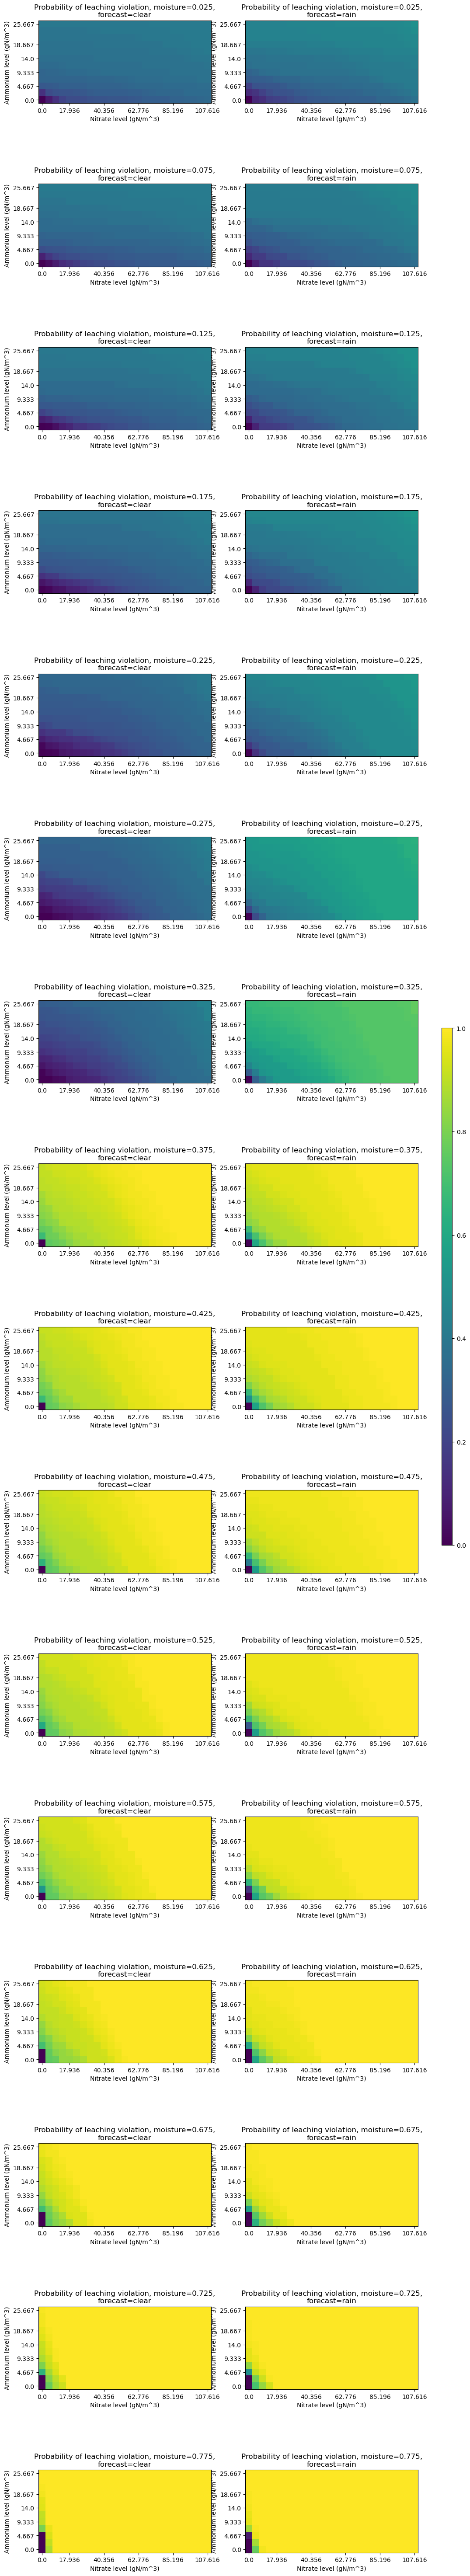

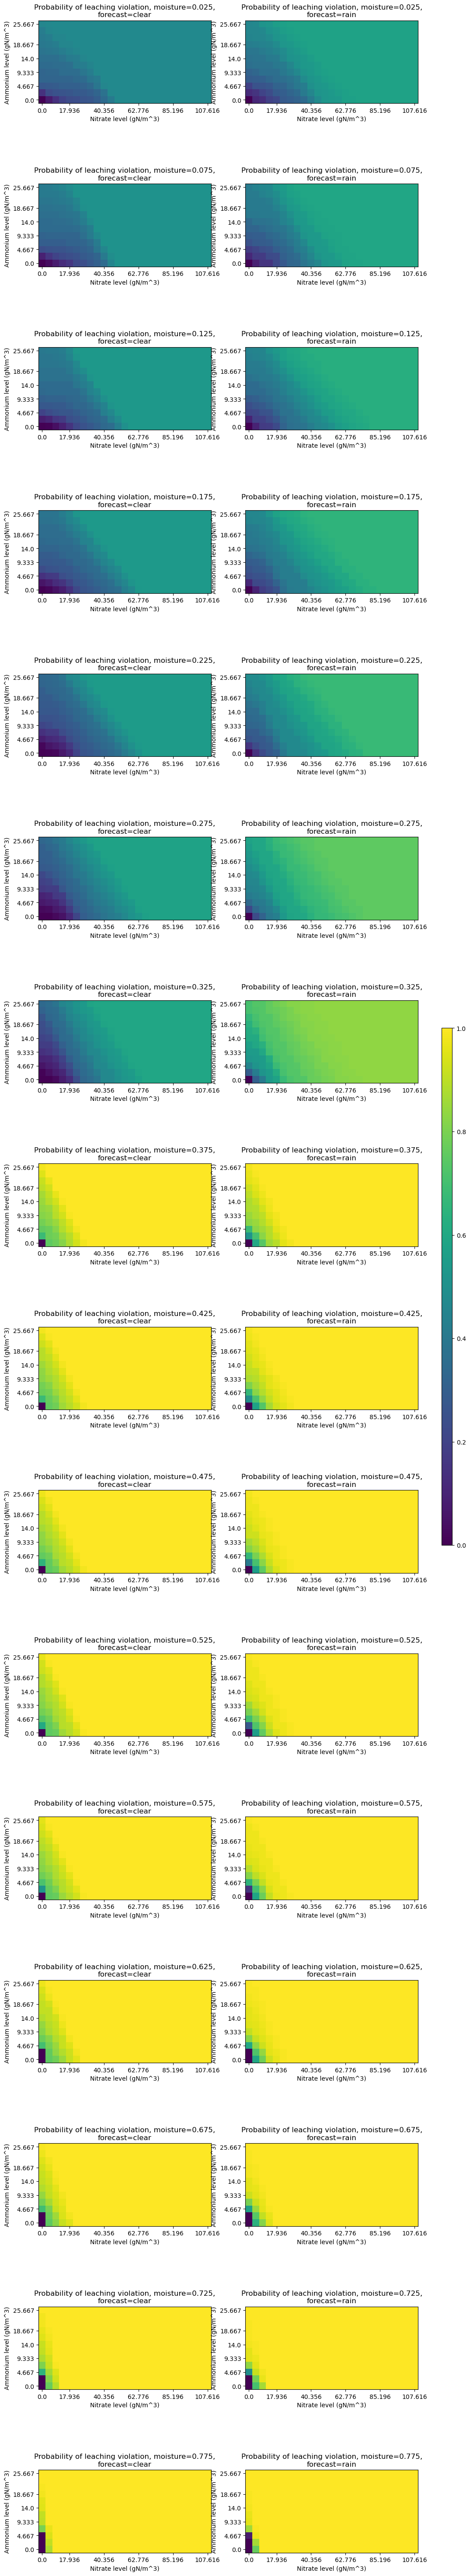

In [17]:
for control_step_idx in [0, NUM_CONTROL_STEPS - 1]:
    fig, axs= plt.subplots(MOISTURE_NUM_STEPS, 2, figsize=[7*2, 4.8 * MOISTURE_NUM_STEPS])
    for moisture_index in range (MOISTURE_NUM_STEPS):
        for forecast in range(2):
            scalar_mappable = display_moisture_slice(np.sum(transition_counts[control_step_idx, forecast, moisture_index, :, :, 1], (2, 3, 4, 5), np.float64) / NUM_TRIALS_PER_INITIAL_CONDITION, "Probability of leaching violation, moisture=" + moisture_idx_to_string(moisture_index) + ",\nforecast=" + ("clear" if forecast == 0 else "rain"), fig=fig, ax=axs[moisture_index,forecast], colorbar=False, vmin=0.0, vmax=1.0)
    fig.colorbar(scalar_mappable, ax=axs, aspect=50, shrink=0.2)

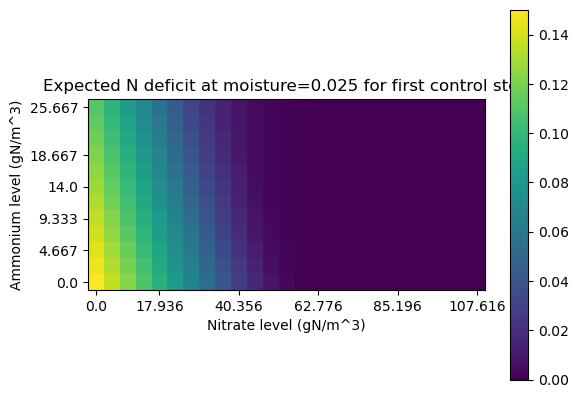

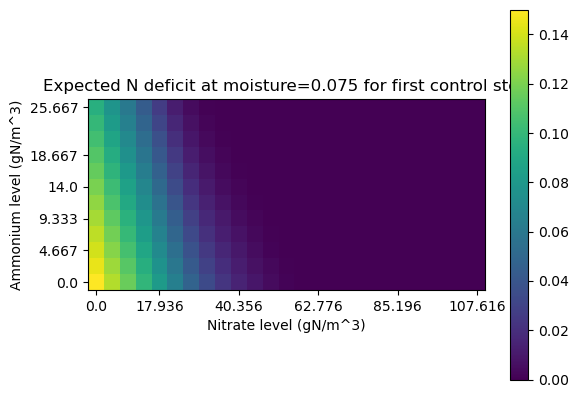

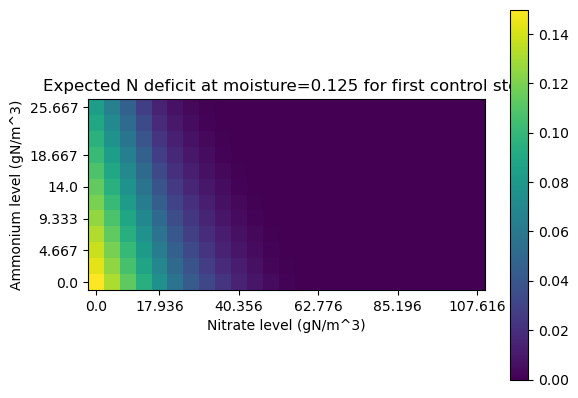

In [18]:
for i in range(3): # should be MOISTURE_NUM_STEPS but I'm tired of scrolling past a million plots
    display_moisture_slice(expected_plant_N_deficit_cost_USD[0, 0, 0, i], "Expected N deficit at moisture=" + moisture_idx_to_string(i) + " for first control step")
# plt.close()

## Solve DP

In [33]:
kernel_metadata = KernelMetadata(NUM_TRIALS_PER_INITIAL_CONDITION, NUM_CONTROL_STEPS, ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS)
n_indices_to_values = lambda ammonium_idx, nitrate_idx: indices_to_values(0, 0, ammonium_idx, nitrate_idx)[2:4]
PARETO_SWEEP_SAMPLES = 50
leaching_penalties_USD_per_m2 = np.linspace(0, LEACHING_VIOLATION_PENALTY_USD_PER_M2 * 4.0, PARETO_SWEEP_SAMPLES)

In [34]:
# time, has leaching been violated, accumulated N, weather forecast, moisture, ammonium, nitrate
low_fine_optimal_cost_to_go_USD_per_m2, low_fine_optimal_ammonium_add_in_cells, low_fine_optimal_nitrate_add_in_cells = solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, kernel_metadata, N_PRICE_USD_PER_G, (SOIL_DEPTH_MM / 1000.), n_indices_to_values, leaching_penalties_USD_per_m2[1] , PROBABILITY_OF_CLEAR_FORECAST)

In [35]:
# Dimensions are: control step, has leaching been violated, accumulated N, weather forecast, moisture, ammonium, nitrate
high_fine_optimal_cost_to_go_USD_per_m2, high_fine_optimal_ammonium_add_in_cells, high_fine_optimal_nitrate_add_in_cells = solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, kernel_metadata, N_PRICE_USD_PER_G, (SOIL_DEPTH_MM / 1000.), n_indices_to_values, leaching_penalties_USD_per_m2[2] , PROBABILITY_OF_CLEAR_FORECAST)

In [12]:
optimal_cost_to_go_USD_per_m2, optimal_ammonium_add_in_cells, optimal_nitrate_add_in_cells = high_fine_optimal_cost_to_go_USD_per_m2, high_fine_optimal_ammonium_add_in_cells, high_fine_optimal_nitrate_add_in_cells

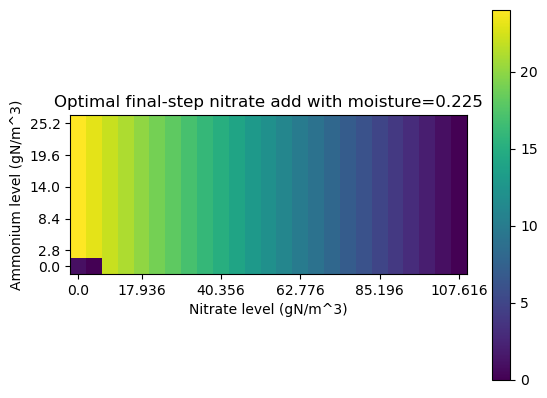

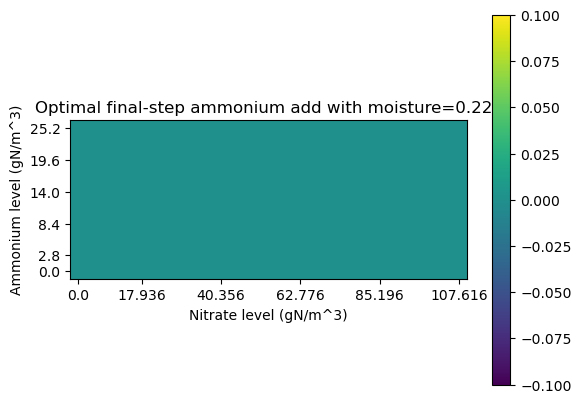

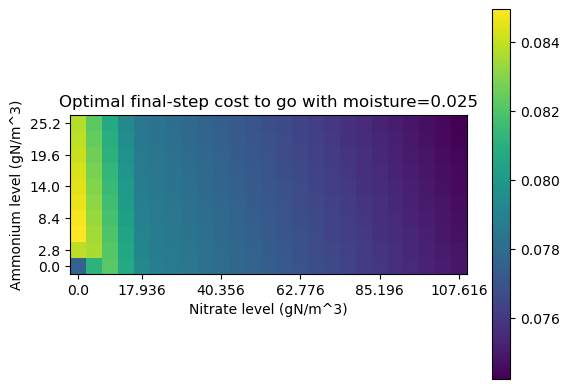

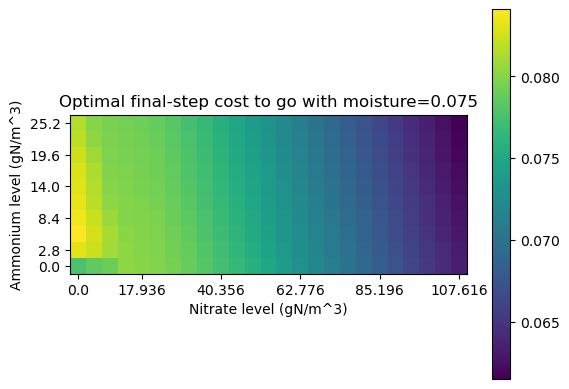

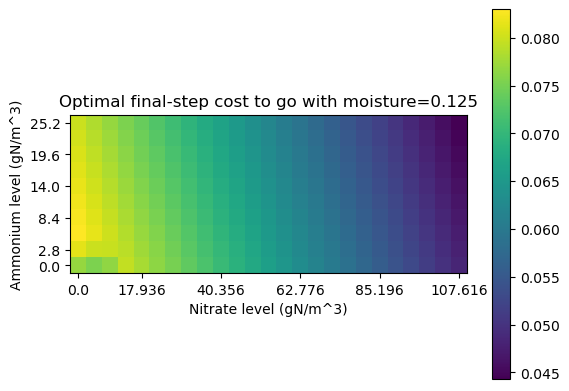

In [17]:
display_moisture_idx = 4
display_accumulated_N_idx = 0
display_moisture_slice(optimal_nitrate_add_in_cells[-1, 0, display_accumulated_N_idx, 0, display_moisture_idx], "Optimal final-step nitrate add with moisture=" + moisture_idx_to_string(display_moisture_idx))
display_moisture_slice(optimal_ammonium_add_in_cells[-1, 0, display_accumulated_N_idx, 0, display_moisture_idx], "Optimal final-step ammonium add with moisture=" + moisture_idx_to_string(display_moisture_idx))
for i in range(3): # should be MOISTURE_NUM_STEPS but i don't wanna scroll past that many plots
    display_moisture_slice(optimal_cost_to_go_USD_per_m2[-1, 0, display_accumulated_N_idx, 0, i], "Optimal final-step cost to go with moisture=" + moisture_idx_to_string(i))

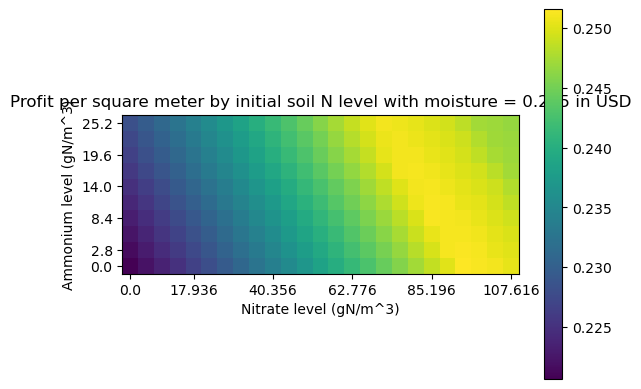

In [13]:
display_moisture_slice(N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - (optimal_cost_to_go_USD_per_m2[0, 0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + optimal_cost_to_go_USD_per_m2[0, 0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)), "Profit per square meter by initial soil N level with moisture = " + moisture_idx_to_string(4) + " in USD")

In [36]:
low_fine_probabilities_of_violation = calculate_probabilities_of_violation(transition_counts, low_fine_optimal_ammonium_add_in_cells, low_fine_optimal_nitrate_add_in_cells, kernel_metadata, PROBABILITY_OF_CLEAR_FORECAST)
high_fine_probabilities_of_violation = calculate_probabilities_of_violation(transition_counts, high_fine_optimal_ammonium_add_in_cells, high_fine_optimal_nitrate_add_in_cells, kernel_metadata, PROBABILITY_OF_CLEAR_FORECAST)

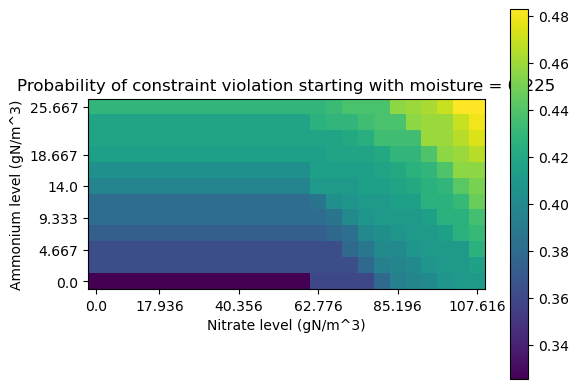

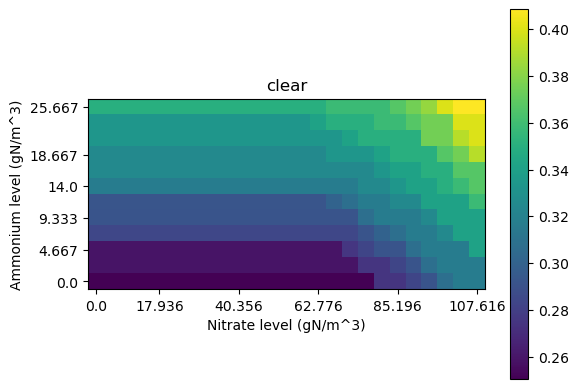

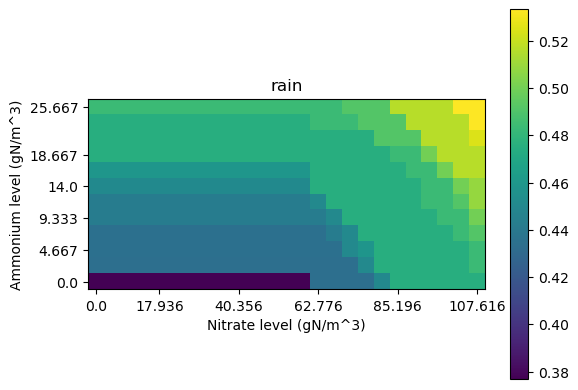

In [24]:
display_moisture_slice((probabilities_of_violation[0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)), "Probability of constraint violation starting with moisture = " + moisture_idx_to_string(4))
display_moisture_slice(probabilities_of_violation[0, 0, 0, 4], title="clear")
display_moisture_slice(probabilities_of_violation[0, 0, 1, 4], title="rain")

In [25]:
PARETO_SWEEP_SAMPLES = 50
leaching_penalties_USD_per_m2 = np.linspace(0, LEACHING_VIOLATION_PENALTY_USD_PER_M2 * 4.0, PARETO_SWEEP_SAMPLES)
pareto_sweep_expected_profit = np.ndarray([PARETO_SWEEP_SAMPLES, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS]) # sample idx, forecast, moisture, ammonium, nitrate
pareto_sweep_probability_of_violation = np.ndarray([PARETO_SWEEP_SAMPLES, 2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS]) # sample idx, forecast, moisture, ammonium, nitrate
for i in range(PARETO_SWEEP_SAMPLES):
    sweep_optimal_cost_to_go_USD_per_m2, sweep_optimal_ammonium_add_in_cells, sweep_optimal_nitrate_add_in_cells = solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, kernel_metadata, N_PRICE_USD_PER_G, (SOIL_DEPTH_MM / 1000.), n_indices_to_values, leaching_penalties_USD_per_m2[i], PROBABILITY_OF_CLEAR_FORECAST)
    sweep_probabilities_of_violation = calculate_probabilities_of_violation(transition_counts, sweep_optimal_ammonium_add_in_cells, sweep_optimal_nitrate_add_in_cells, kernel_metadata, PROBABILITY_OF_CLEAR_FORECAST)
    pareto_sweep_expected_profit[i] = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - sweep_optimal_cost_to_go_USD_per_m2[0, 0, 0]
    pareto_sweep_probability_of_violation[i] = sweep_probabilities_of_violation[0, 0]

In [39]:
weights_for_pareto = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
weights_for_pareto[:, 0, 0:2, 0:5] = 0.05
weights_for_pareto[:, 1, 0:2, 0:5] = 0.33
weights_for_pareto[:, 2, 0:2, 0:5] = 0.18
weights_for_pareto[:, 3, 0:2, 0:5] = 0.15
weights_for_pareto[:, 4, 0:2, 0:5] = 0.15
weights_for_pareto[:, 5, 0:2, 0:5] = 0.14
weights_for_pareto[0] *= PROBABILITY_OF_CLEAR_FORECAST
weights_for_pareto[1] *= (1 - PROBABILITY_OF_CLEAR_FORECAST)
weights_for_pareto /= np.sum(weights_for_pareto)

In [40]:
print(np.average(low_fine_optimal_cost_to_go_USD_per_m2[0, 0, 0], weights=weights_for_pareto))
print(np.average(low_fine_probabilities_of_violation[0, 0], weights=weights_for_pareto))
print(np.average(high_fine_optimal_cost_to_go_USD_per_m2[0, 0, 0], weights=weights_for_pareto))
print(np.average(high_fine_probabilities_of_violation[0, 0], weights=weights_for_pareto))

0.03621636158210567
0.3695161216273259
0.04430795915099365
0.3677126284035935


In [38]:
# time, accumulated N, weather forecast, moisture, ammonium, nitrate
low_pre_fine_cost_to_go = low_fine_optimal_cost_to_go_USD_per_m2[:, 0]  - leaching_penalties_USD_per_m2[1] * low_fine_probabilities_of_violation
high_pre_fine_cost_to_go = high_fine_optimal_cost_to_go_USD_per_m2[:, 0]  - leaching_penalties_USD_per_m2[2] * high_fine_probabilities_of_violation

In [39]:
high_fine_pre_advantage = low_pre_fine_cost_to_go - high_pre_fine_cost_to_go

In [46]:
print(np.average(low_pre_fine_cost_to_go[0, 0], weights=weights_for_pareto))
print(np.average(high_pre_fine_cost_to_go[0, 0], weights=weights_for_pareto))
print(np.average(high_fine_pre_advantage[0, 0], weights=weights_for_pareto))

0.02812151088837073
0.028197274658965196
-7.576377059446804e-05


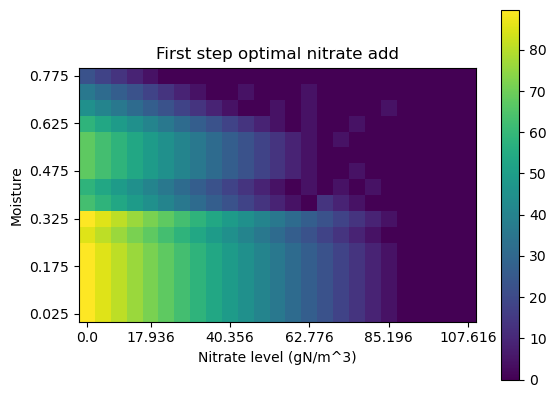

In [59]:
display_ammonium_slice(high_fine_optimal_nitrate_add_in_cells[0, 0, 0, 0, :, 0] * NITRATE_GRID_SIZE, "First step optimal nitrate add")

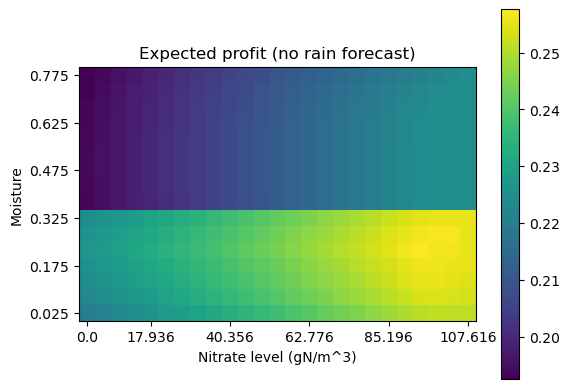

In [25]:
display_ammonium_slice(N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - high_fine_optimal_cost_to_go_USD_per_m2[0, 0, 0, 0, :, 0], "Expected profit (no rain forecast)")


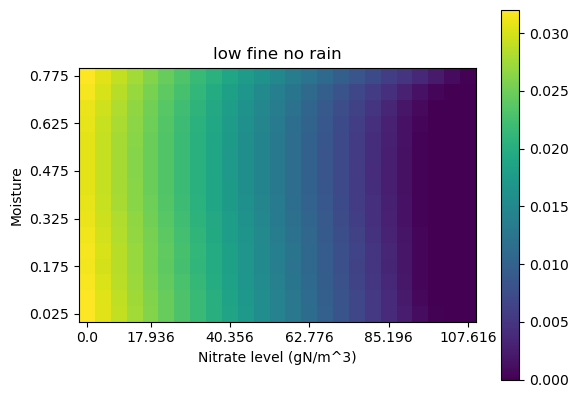

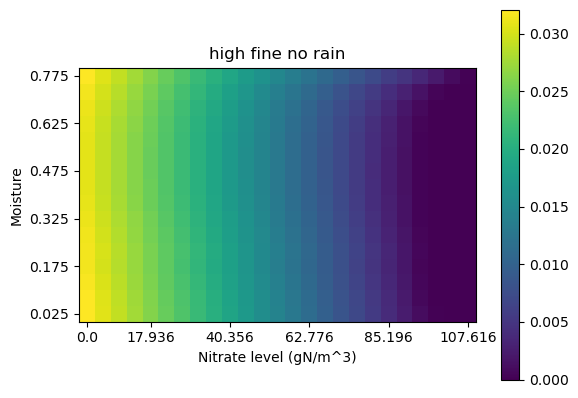

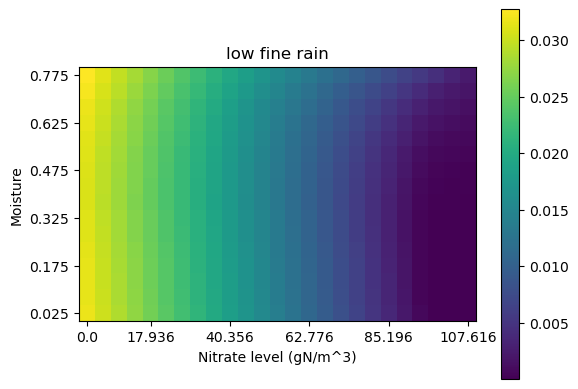

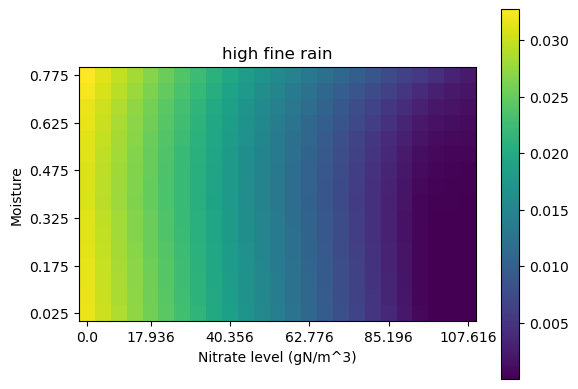

In [44]:
# time, accumulated N, weather forecast, moisture, ammonium, nitrate
display_ammonium_slice(low_pre_fine_cost_to_go[0, 0, 0, :, 0], "low fine no rain")
display_ammonium_slice(high_pre_fine_cost_to_go[0, 0, 0, :, 0], "high fine no rain")
display_ammonium_slice(low_pre_fine_cost_to_go[0, 0, 1, :, 0], "low fine rain")
display_ammonium_slice(high_pre_fine_cost_to_go[0, 0, 1, :, 0], "high fine rain")

In [45]:
print(np.max(high_fine_pre_advantage[3]))
print(np.max(high_fine_pre_advantage[2]))
print(np.max(high_fine_pre_advantage[1]))
print(np.max(high_fine_pre_advantage[0]))

2.0816681711721685e-17
5.551115123125783e-17
3.469446951953614e-17
0.022830623879049515


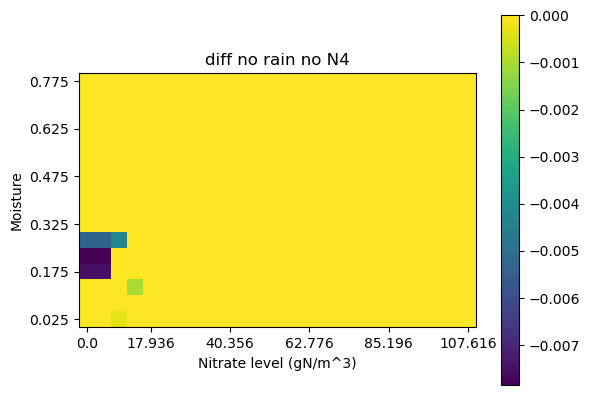

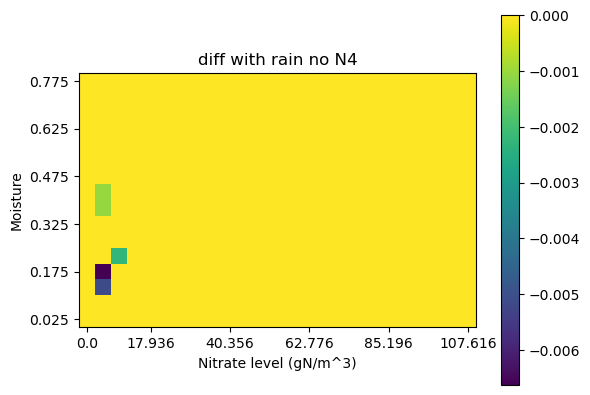

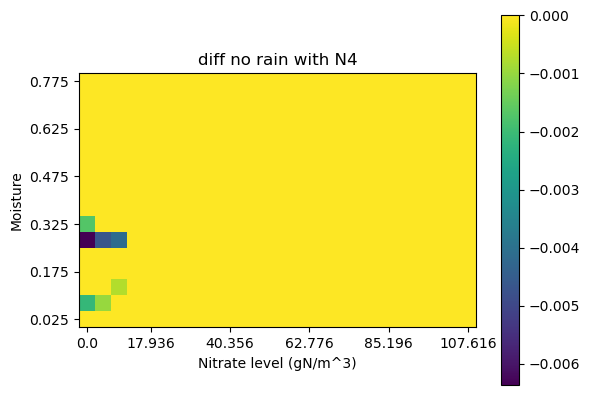

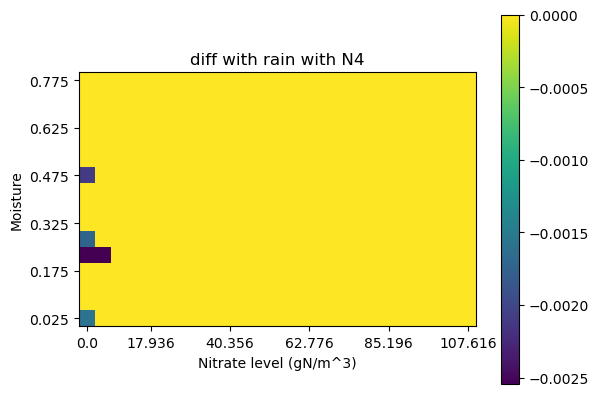

In [27]:
display_ammonium_slice(high_fine_pre_advantage[-1, 0, 0, :, 0], "diff no rain no N4")
display_ammonium_slice(high_fine_pre_advantage[-1, 0, 1, :, 0], "diff with rain no N4")
display_ammonium_slice(high_fine_pre_advantage[-1, 0, 0, :, 1], "diff no rain with N4")
display_ammonium_slice(high_fine_pre_advantage[-1, 0, 1, :, 1], "diff with rain with N4")

In [19]:
low_fine_total_N_add = low_fine_optimal_ammonium_add_in_cells + low_fine_optimal_nitrate_add_in_cells
high_fine_total_N_add = high_fine_optimal_ammonium_add_in_cells + high_fine_optimal_nitrate_add_in_cells
extra_N_with_high_fine = np.subtract(high_fine_total_N_add, low_fine_total_N_add, dtype=np.int16)

In [20]:
for i in reversed(range(NUM_CONTROL_STEPS)):
    print(np.max(extra_N_with_high_fine[i]))

0
2
2
21


In [40]:
for i in reversed(range(NUM_CONTROL_STEPS)):
    print(np.min(high_pre_fine_cost_to_go[i]))

0.0
-1.0408340855860843e-17
-1.3877787807814457e-17
-6.938893903907228e-18


In [41]:
for i in reversed(range(NUM_CONTROL_STEPS)):
    print(np.min(high_fine_probabilities_of_violation[i]), "to", np.max(high_fine_probabilities_of_violation[i]))

0.0 to 1.0
0.0 to 1.0
0.0 to 1.0
0.0 to 1.0


In [42]:
for i in reversed(range(NUM_CONTROL_STEPS)):
    print(np.min(high_fine_optimal_cost_to_go_USD_per_m2[i]))

0.0
0.0
0.0
0.0


In [43]:
# accumulated N, weather forecast, moisture, ammonium, nitrate
np.unravel_index(np.argmin(high_pre_fine_cost_to_go[0]), high_pre_fine_cost_to_go[0].shape)

(np.int64(0), np.int64(1), np.int64(3), np.int64(9), np.int64(23))

In [44]:
print(high_fine_probabilities_of_violation[0, 1, 1, 7, 0, 9])
print(high_pre_fine_cost_to_go[0, 1, 1, 7, 0, 9])
print(high_fine_optimal_cost_to_go_USD_per_m2[0, 0, 1, 1, 7, 0, 9])

1.0
0.01687292073136295
0.06068616848946198


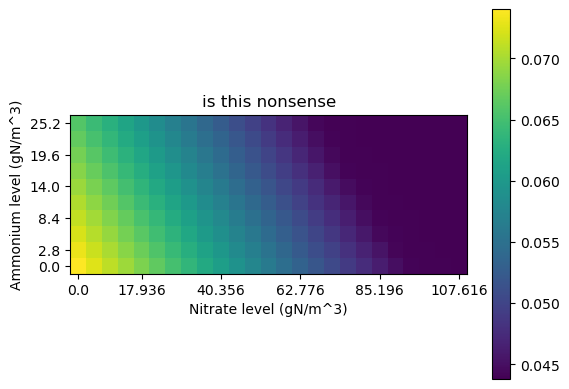

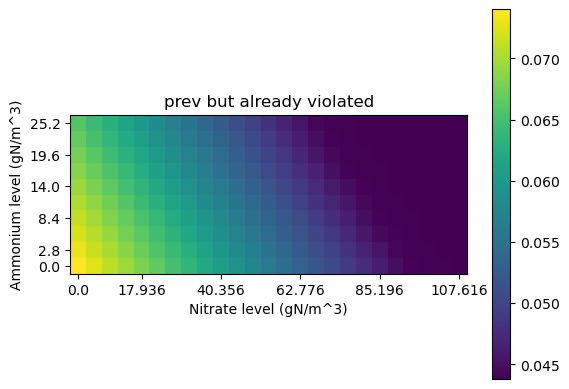

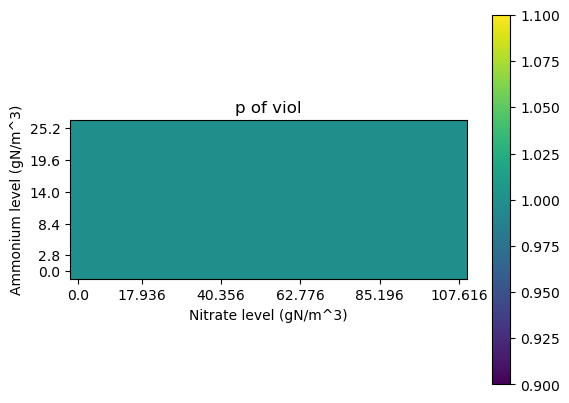

In [45]:
display_moisture_slice(high_fine_optimal_cost_to_go_USD_per_m2[0, 0, 1, 1, 7], "is this nonsense")
display_moisture_slice(high_fine_optimal_cost_to_go_USD_per_m2[0, 1, 1, 1, 7], "prev but already violated")
display_moisture_slice(high_fine_probabilities_of_violation[0, 1, 1, 7], "p of viol")

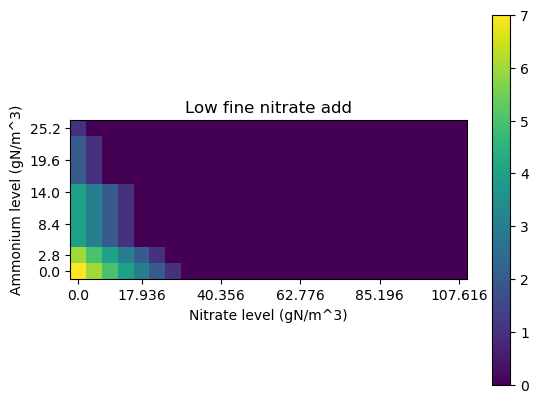

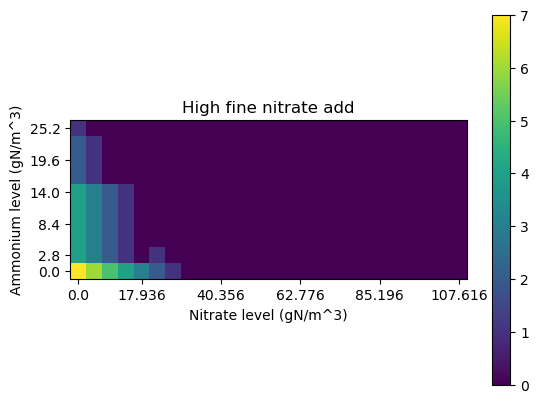

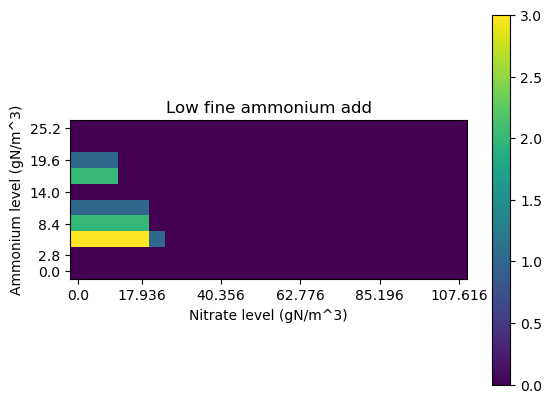

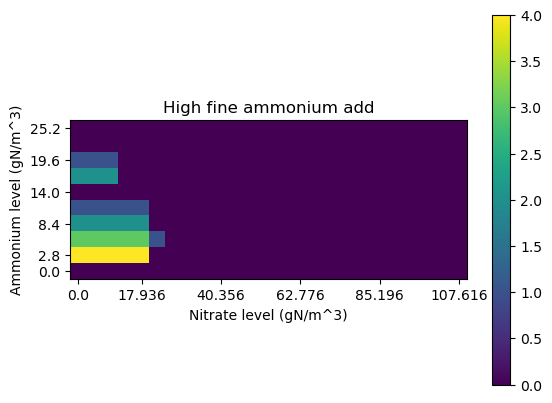

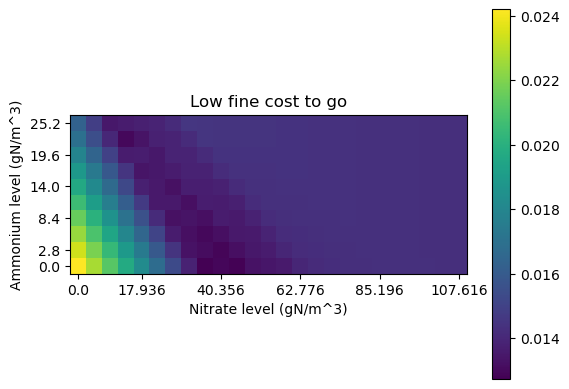

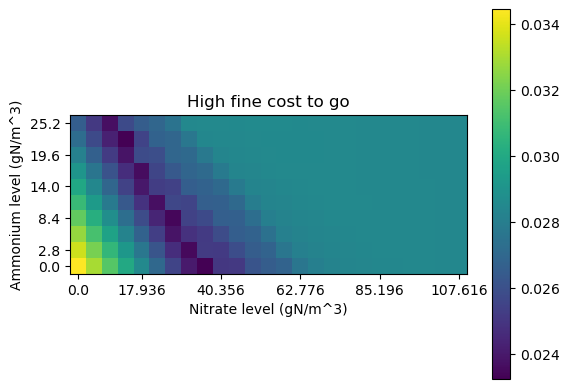

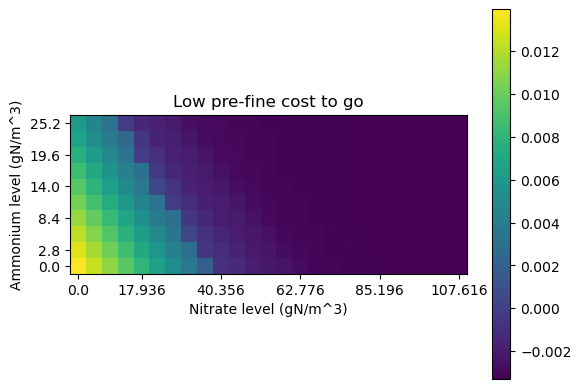

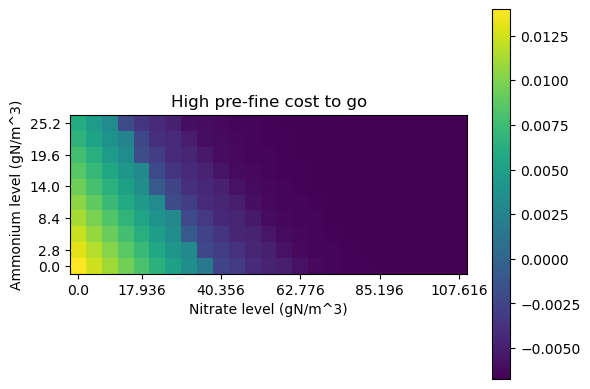

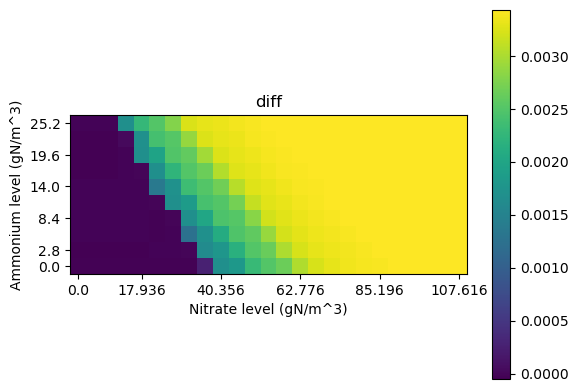

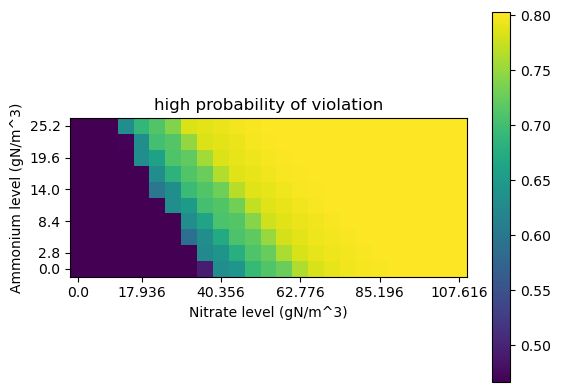

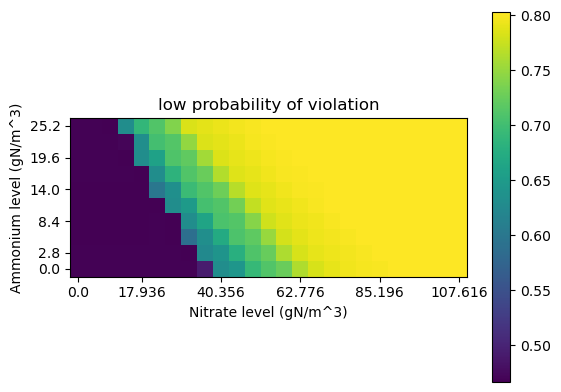

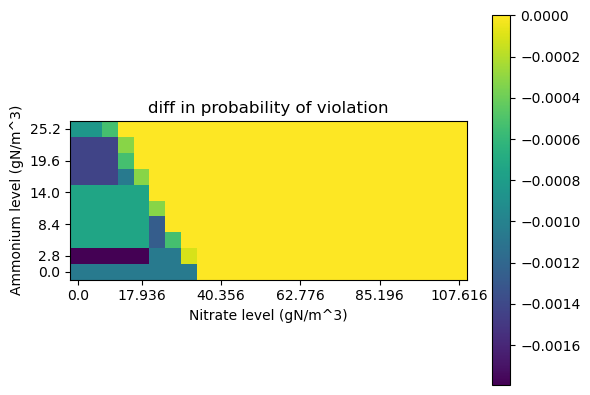

In [28]:
display_moisture_slice(low_fine_optimal_nitrate_add_in_cells[2, 0, 28, 1, 4], "Low fine nitrate add")
display_moisture_slice(high_fine_optimal_nitrate_add_in_cells[2, 0, 28, 1, 4], "High fine nitrate add")
display_moisture_slice(low_fine_optimal_ammonium_add_in_cells[2, 0, 28, 1, 4], "Low fine ammonium add")
display_moisture_slice(high_fine_optimal_ammonium_add_in_cells[2, 0, 28, 1, 4], "High fine ammonium add")
display_moisture_slice(low_fine_optimal_cost_to_go_USD_per_m2[2, 0, 28, 1, 4], "Low fine cost to go")
display_moisture_slice(high_fine_optimal_cost_to_go_USD_per_m2[2, 0, 28, 1, 4], "High fine cost to go")
display_moisture_slice(low_pre_fine_cost_to_go[2, 28, 1, 4], "Low pre-fine cost to go")
display_moisture_slice(high_pre_fine_cost_to_go[2, 28, 1, 4], "High pre-fine cost to go")
display_moisture_slice(high_fine_pre_advantage[2, 28, 1, 4], "diff")
display_moisture_slice(high_fine_probabilities_of_violation[2, 28, 1, 4], "high probability of violation")
display_moisture_slice(low_fine_probabilities_of_violation[2, 28, 1, 4], "low probability of violation")
display_moisture_slice(high_fine_probabilities_of_violation[2, 28, 1, 4] - low_fine_probabilities_of_violation[2, 28, 1, 4], "diff in probability of violation")

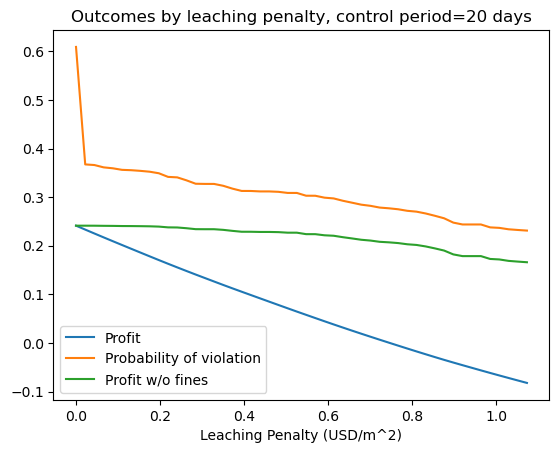

In [27]:
pareto_average_profits = np.average(pareto_sweep_expected_profit, axis=(1, 2, 3, 4), weights=weights_for_pareto)
pareto_average_probabilities_of_violation = np.average(pareto_sweep_probability_of_violation, axis=(1, 2, 3, 4), weights=weights_for_pareto)
pareto_average_pre_fine_profits = pareto_average_profits + (pareto_average_probabilities_of_violation * leaching_penalties_USD_per_m2)
plt.plot(leaching_penalties_USD_per_m2, pareto_average_profits, label="Profit")
plt.plot(leaching_penalties_USD_per_m2, pareto_average_probabilities_of_violation, label="Probability of violation")
plt.plot(leaching_penalties_USD_per_m2, pareto_average_pre_fine_profits, label="Profit w/o fines")
plt.title("Outcomes by leaching penalty, control period=" + str(CONTROL_TIMESTEP_DAYS) + " days")
plt.xlabel("Leaching Penalty (USD/m^2)")
plt.legend(loc="lower left")

Text(0.5, 0, 'Probability of violation')

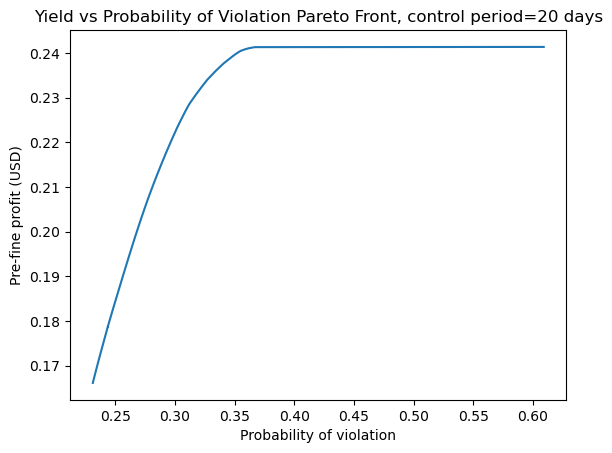

In [28]:
plt.plot(pareto_average_probabilities_of_violation, pareto_average_pre_fine_profits)
plt.title("Yield vs Probability of Violation Pareto Front, control period=" + str(CONTROL_TIMESTEP_DAYS) + " days")
plt.ylabel("Pre-fine profit (USD)")
plt.xlabel("Probability of violation")

In [29]:
# time, has leaching been violated, accumulated N, weather forecast, moisture, ammonium, nitrate
no_fertilizer_cost_to_go_USD_per_m2, _, _ = solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, kernel_metadata, 999999.9, (SOIL_DEPTH_MM / 1000.), n_indices_to_values, 0.0, PROBABILITY_OF_CLEAR_FORECAST)

In [30]:
no_fertilizer_violation_probabilites = calculate_probabilities_of_violation(transition_counts, np.zeros(optimal_ammonium_add_in_cells.shape, dtype=np.uint8), np.zeros(optimal_nitrate_add_in_cells.shape, dtype=np.uint8), kernel_metadata, PROBABILITY_OF_CLEAR_FORECAST)

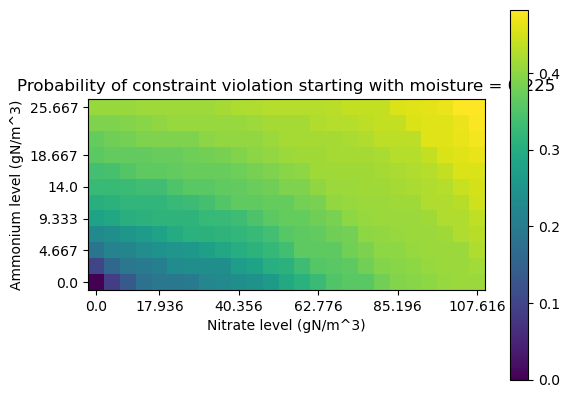

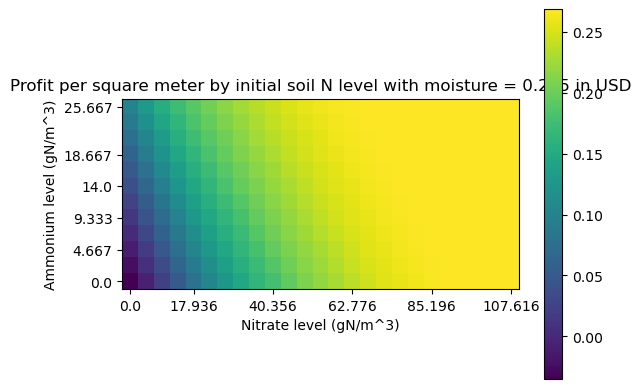

In [31]:
display_moisture_slice((no_fertilizer_violation_probabilites[0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + no_fertilizer_violation_probabilites[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)), "Probability of constraint violation starting with moisture = " + moisture_idx_to_string(4))
display_moisture_slice(N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - (
            no_fertilizer_cost_to_go_USD_per_m2[0, 0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST +
            no_fertilizer_cost_to_go_USD_per_m2[0, 0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)),
                       "Profit per square meter by initial soil N level with moisture = " + moisture_idx_to_string(
                           4) + " in USD")

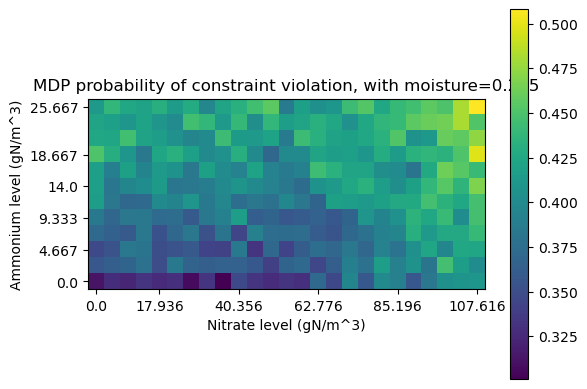

In [32]:
MDP_violation_probabilities = np.zeros([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
num_MPD_trials = 1000
# forecast, moisture, post-add ammonium, post-add nitrate
violation_locations = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint16)
for i in range(num_MPD_trials):
    for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
        for initial_nitrate_index in range(NITRATE_NUM_STEPS):
            accumulated_N_idx = 0
            current_moisture_idx = 4
            current_ammonium_idx = initial_ammonium_index
            current_nitrate_idx = initial_nitrate_index
            violated_constraint_yet = 0
            for control_step in range(NUM_CONTROL_STEPS):
                # Decide forecast
                forecast = 0 if rng.random() <= PROBABILITY_OF_CLEAR_FORECAST else 1

                # Fertilize according to controller
                ammonium_add = optimal_ammonium_add_in_cells[control_step, violated_constraint_yet, accumulated_N_idx, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                nitrate_add = optimal_nitrate_add_in_cells[control_step, violated_constraint_yet, accumulated_N_idx, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                current_ammonium_idx += ammonium_add
                current_nitrate_idx += nitrate_add

                # Sample transition from kernel
                relevant_kernel_region = transition_counts[control_step, forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx]
                possible_outcomes = []
                for nonzero_indicies in np.argwhere(relevant_kernel_region):
                    for num_counts in range(relevant_kernel_region[*nonzero_indicies]):
                        possible_outcomes.append(nonzero_indicies)
                transition_destination = rng.choice(possible_outcomes) # dimensions are: resulting leaching violation, resulting N accumulation, resulting moisture, resulting ammonium, resulting nitrate
                if initial_ammonium_index == 0 and initial_nitrate_index == 0 and violated_constraint_yet == 0 and transition_destination[0] == 1:
                    violation_locations[forecast, current_moisture_idx, current_ammonium_idx, current_nitrate_idx] += 1
                violated_constraint_yet = min(1, violated_constraint_yet + transition_destination[0])
                accumulated_N_idx = min(ACCUMULATED_N_NUM_STEPS, accumulated_N_idx + transition_destination[1])
                current_moisture_idx = transition_destination[2]
                current_ammonium_idx = transition_destination[3]
                current_nitrate_idx = transition_destination[4]
            MDP_violation_probabilities[initial_ammonium_index, initial_nitrate_index] += violated_constraint_yet
MDP_violation_probabilities /= num_MPD_trials
display_moisture_slice(MDP_violation_probabilities, "MDP probability of constraint violation, with moisture=" + moisture_idx_to_string(4))

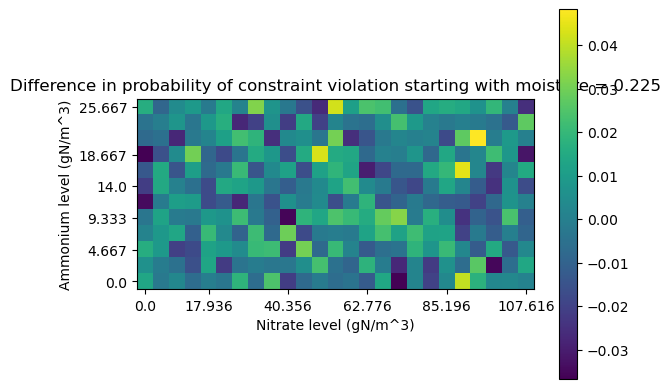

In [33]:
display_moisture_slice((probabilities_of_violation[0, 0, 0, 4] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)) - MDP_violation_probabilities, "Difference in probability of constraint violation starting with moisture = " + moisture_idx_to_string(4))

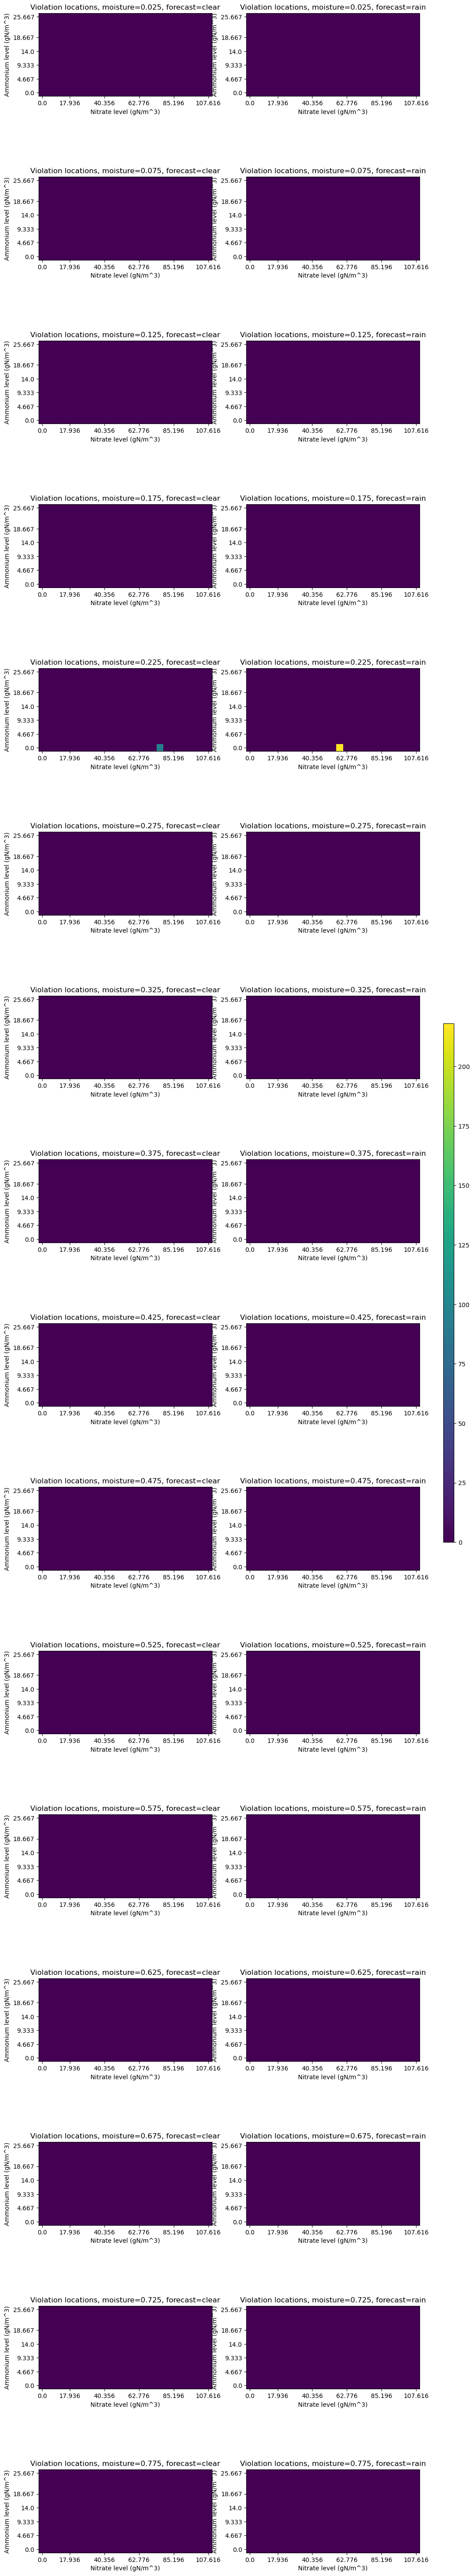

In [34]:
fig, axs = plt.subplots(MOISTURE_NUM_STEPS, 2, figsize=[7*2, 4.8 * MOISTURE_NUM_STEPS])
for moisture_index in range(MOISTURE_NUM_STEPS):
    for forecast in range(2):
        scalar_mappable = display_moisture_slice(violation_locations[forecast, moisture_index], "Violation locations, moisture="+moisture_idx_to_string(moisture_index)+ ", forecast=" + ("clear" if forecast == 0 else "rain"), fig=fig, ax=axs[moisture_index, forecast], colorbar=False, vmin=0, vmax=np.max(violation_locations))
fig.colorbar(scalar_mappable, ax=axs, aspect=50, shrink=0.2)

# Testing

In [32]:
if True:
    with open('9_transition_counts.pickle', 'rb') as f:
        transition_counts = pickle.load(f)
    with open('9_expected_plant_N_deficit.pickle', 'rb') as f:
        expected_plant_N_deficit_cost_USD = pickle.load(f)
    # with open('optimal_cost_to_go_USD_per_m2.pickle', 'rb') as f:
    #     optimal_cost_to_go_USD_per_m2 = pickle.load(f)
    # with open('optimal_nitrate_add_in_cells.pickle', 'rb') as f:
    #     optimal_nitrate_add_in_cells = pickle.load(f)
    # with open('optimal_ammonium_add_in_cells.pickle', 'rb') as f:
    #     optimal_ammonium_add_in_cells = pickle.load(f)

In [32]:
def run_controller(control_period_days: int, num_control_periods: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = INITIAL_LITTER_CARBON_GC_PER_M3, initial_litter_nitrogen_gN_per_m3: float = INITIAL_LITTER_NITROGEN_GN_PER_M3, initial_microbial_carbon_gC_per_m3: float = INITIAL_MICROBIAL_CARBON_GC_PER_M3, initial_humus_carbon_gC_per_m3: float = INITIAL_HUMUS_CARBON_GC_PER_M3, generate_figures: bool = True):
    rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    ammonium_adds = np.ndarray(num_control_periods)
    nitrate_adds = np.ndarray(num_control_periods)
    forecasts = np.ndarray(num_control_periods)
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_ammonium_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_accumulated_N_gN_per_m3 = np.zeros(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0
    leaching_violated_yet = 0
    leaching_limit_violated_per_step = np.ndarray(num_control_periods, np.bool)

    for i in range(num_control_periods):
        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        indices = values_to_indices(soil_moisture[i * control_period_days], ammonium_gN_per_m3, nitrate_gN_per_m3)
        accumulated_N_index = accumulated_N_value_to_index(accumulated_N_gN_per_m3)
        is_rain_forecast = int(any(rain_quantity_mm[start_day:start_day+FORECAST_LOOKAHEAD_DAYS] > 0))
        forecasts[i] = is_rain_forecast
        target_ammonium_index = optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[1]
        target_nitrate_index = optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[2]
        if target_ammonium_index == indices[1]:
            ammonium_adds[i] = 0
        else:
            ammonium_adds[i] = indices_to_values(0, 0, target_ammonium_index, 0)[2] - ammonium_gN_per_m3
        if target_nitrate_index == indices[2]:
            nitrate_adds[i] = 0
        else:
            nitrate_adds[i] = indices_to_values(0, 0, 0, target_nitrate_index)[3] - nitrate_gN_per_m3

        if generate_figures:
            fig, axs = plt.subplots(1, 4, figsize=[7*4, 4.8])

            forecast_str = "rain" if is_rain_forecast == 1 else "clear"

            display_moisture_slice(optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * AMMONIUM_GRID_SIZE, "Optimal ammonium add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0])
            display_moisture_slice(optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * NITRATE_GRID_SIZE, "Optimal nitrate add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[1])
            display_moisture_slice(optimal_cost_to_go_USD_per_m2[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]], "Optimal cost to go for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2])
            axs[3].set_title("N accumulation progress")
            x_series = np.arange(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS)) * INORGANIC_N_MODEL_DT_DAYS
            axs[3].plot(x_series[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], label="actual")
            axs[3].plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
            axs[3].set_ylabel("Total plant N accumulation (gN/m^3)")
            axs[3].set_xlabel("Day")
            axs[3].legend(loc="upper left")

        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], day_to_plant_N_demand_gN_per_m3_per_day, output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrate_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_leaching_gN_per_m3_per_day
        total_ammonium_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_leaching_gN_per_m3_per_day

        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = np.cumsum(combined_N_uptake * INORGANIC_N_MODEL_DT_DAYS) + accumulated_N_gN_per_m3
        total_nitrogen_deficit_cost += nitrogen_deficit_cost(total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], float(start_day), INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = total_plant_accumulated_N_gN_per_m3[int(end_day / INORGANIC_N_MODEL_DT_DAYS) - 1]

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]
        leaching_limit_violated_per_step[i] = leaching_limit_violated(leakage_rate_mm_per_day[start_day : end_day], ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, INORGANIC_N_MODEL_DT_DAYS)
        if leaching_violated_yet == 0:
            leaching_violated_yet = int(leaching_limit_violated_per_step[i])

    return total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, total_ammonium_leaching_gN_per_m3_per_day, total_nitrate_leaching_gN_per_m3_per_day, total_plant_accumulated_N_gN_per_m3, leaching_violated_yet == 1 , leaching_limit_violated_per_step, forecasts

Lost yield due to N deficit: 0.00036997245838524885
Revenue: 0.2679861700599713
Expenditures: 0.029829030000000003
Profit: 0.23815714005997127
Leaching limit violated: True


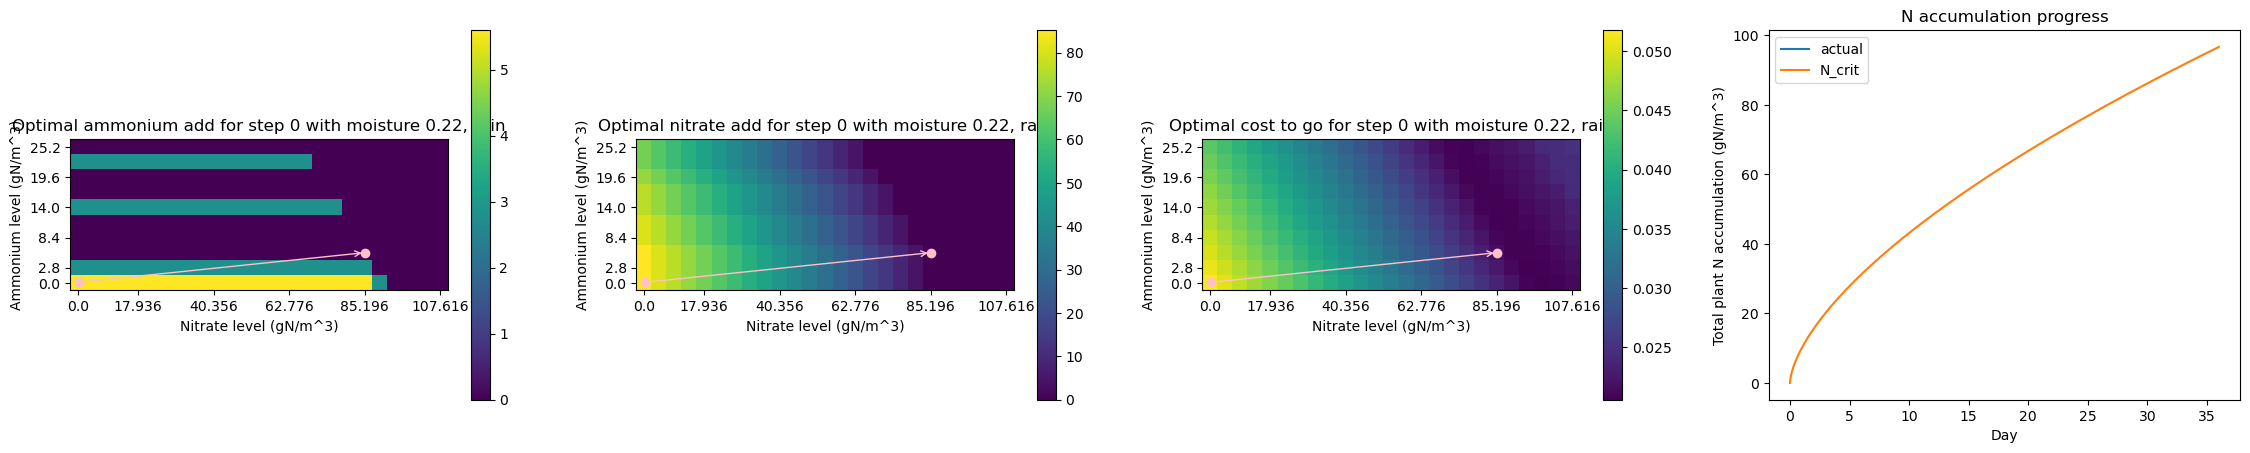

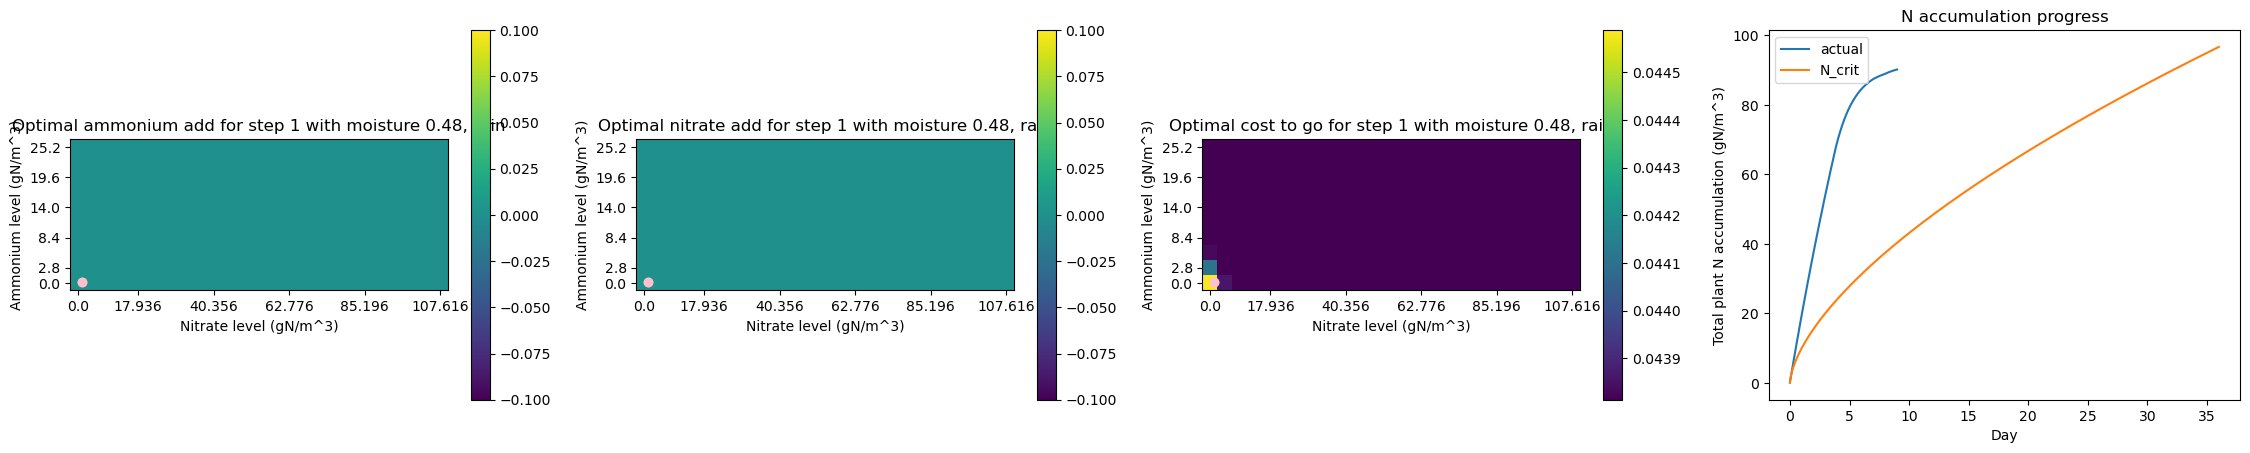

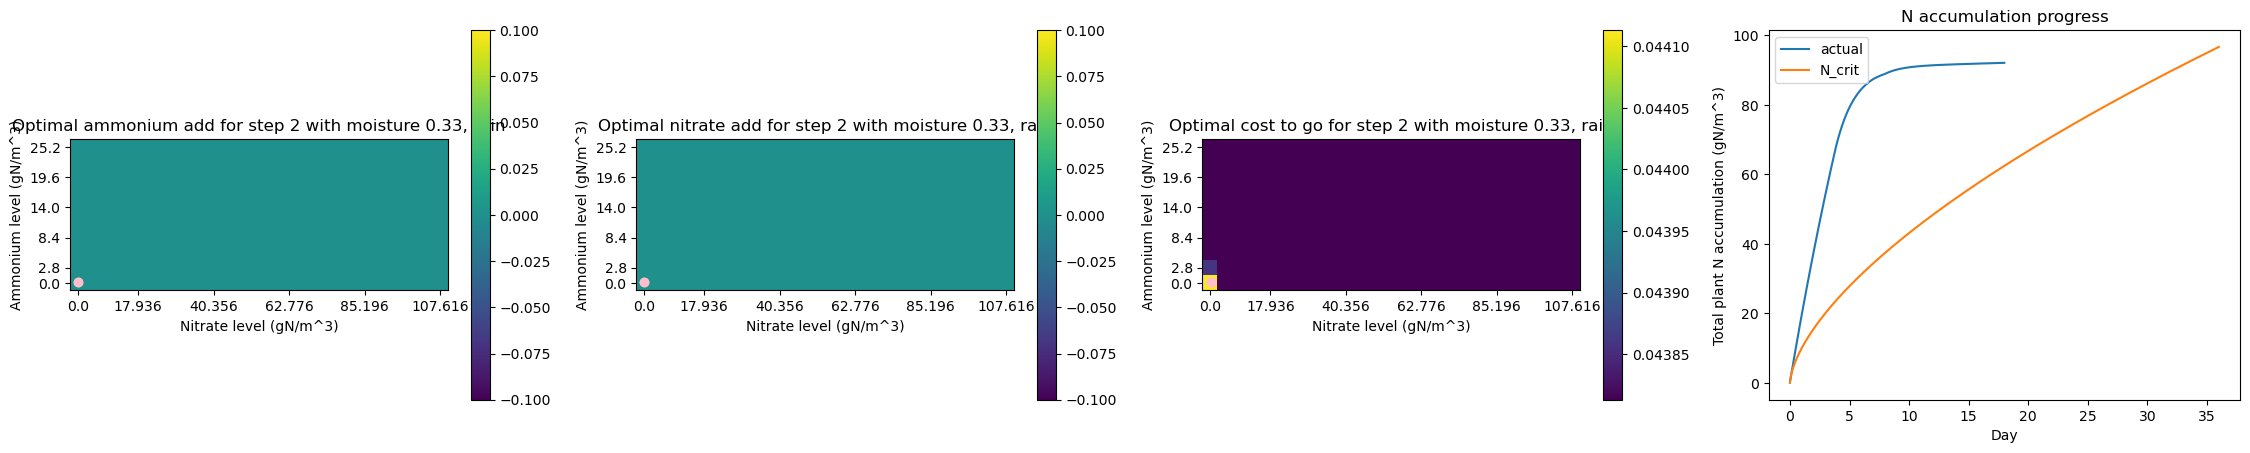

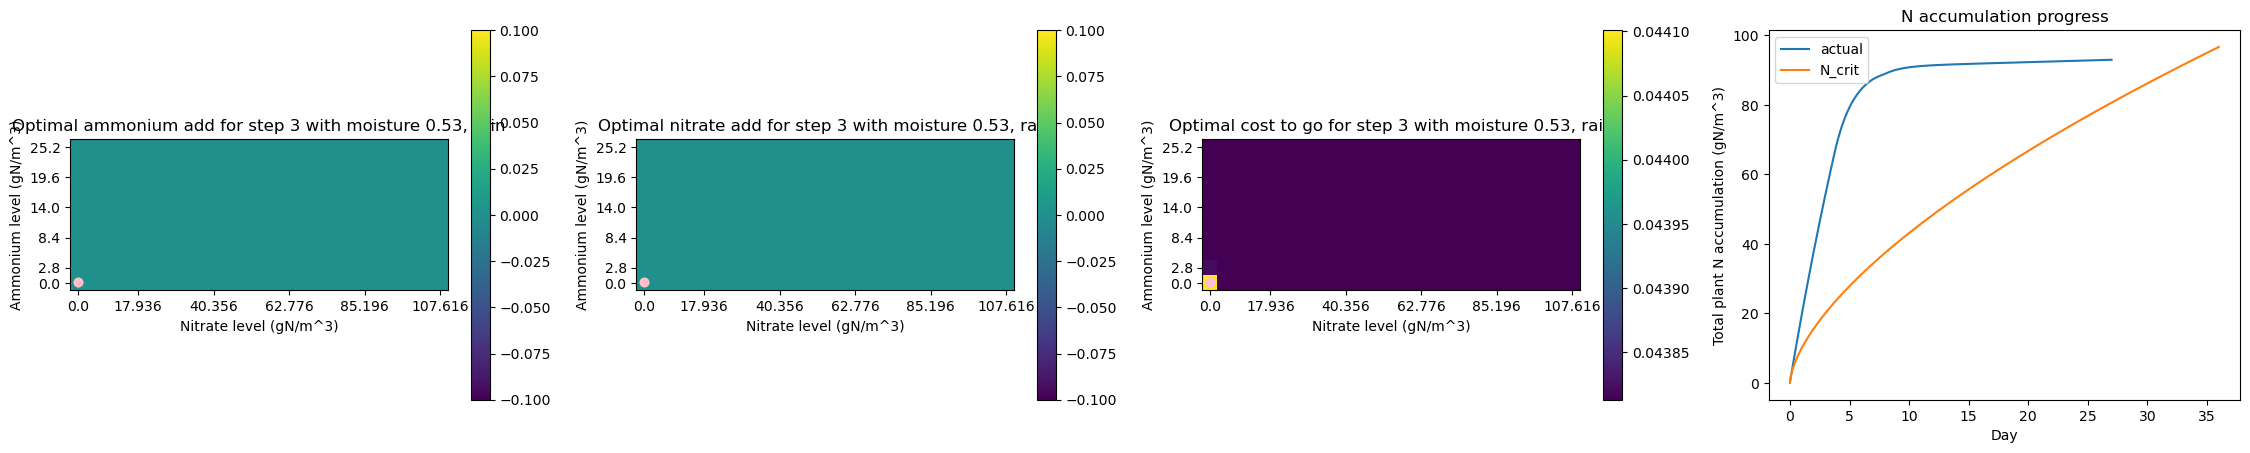

In [33]:
deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N, experiment_leaching_limit_violated, experiment_per_step_leaching_limit_violated, experiment_forecasts = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.225, 0.105, 0.3)
revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
print("Lost yield due to N deficit: {}\nRevenue: {}\nExpenditures: {}\nProfit: {}".format(deficit_cost, revenue, expenditures, revenue - expenditures))
print("Leaching limit violated:", experiment_leaching_limit_violated)

[(0.0, 58.292), Text(0.5, 0, 'nitrate')]

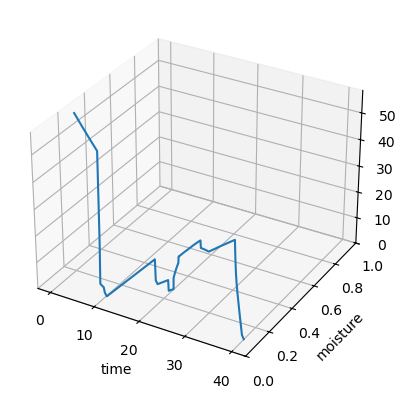

In [38]:
inorganic_n_times = np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS, len(ammonium))
upsampled_soil_moisture = np.interp(inorganic_n_times, np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS, len(experiment_soil_moisture)), experiment_soil_moisture)
maximum_n = max(np.max(ammonium), np.max(nitrate))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(inorganic_n_times, upsampled_soil_moisture, nitrate)
ax.set(xlabel="time")
ax.set(ylim3d=(0, 1), ylabel="moisture")
ax.set(zlim3d=(0, maximum_n), zlabel="nitrate")

In [39]:
added_ammonium

array([ 0.        , 25.51202749])

In [52]:
added_nitrate

array([84.896,  0.   ,  0.   ,  0.   ])

In [41]:
minimum_nitrate_add = []
for i in range(NUM_CONTROL_STEPS):
    control_time_nitrate_idx = values_to_indices(0, 0.1, nitrate[i * int(CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)])[1]
    minimum_nitrate_add.append(indices_to_values(0, 0, 0, control_time_nitrate_idx + 1)[3] - indices_to_values(0, 0, 0, control_time_nitrate_idx)[3])
minimum_nitrate_add

[4.484, 4.484]

Text(0, 0.5, 'Nitrate concentration (gN/m^3)')

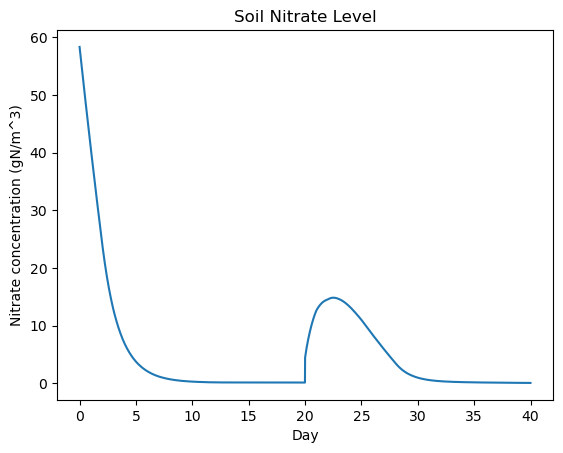

In [42]:
plt.plot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate)
plt.title("Soil Nitrate Level")
plt.xlabel("Day")
plt.ylabel("Nitrate concentration (gN/m^3)")

Text(0, 0.5, 'Ammonium concentration (gN/m^3)')

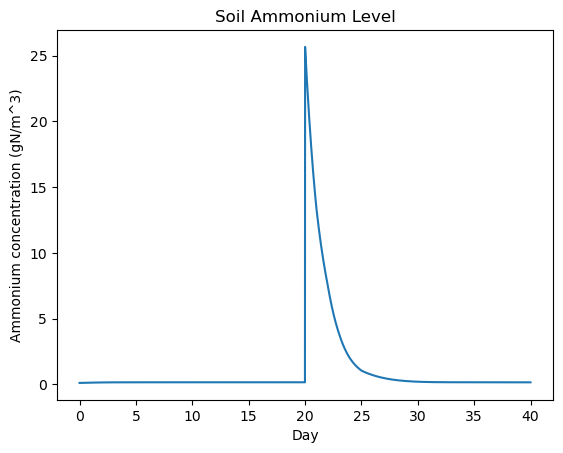

In [43]:
plt.plot(np.arange(len(ammonium)) * INORGANIC_N_MODEL_DT_DAYS, ammonium)
plt.title("Soil Ammonium Level")
plt.xlabel("Day")
plt.ylabel("Ammonium concentration (gN/m^3)")

Text(0.5, 0, 'Day')

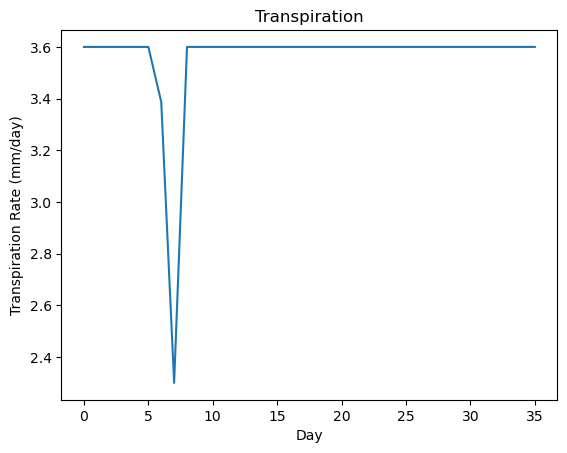

In [56]:
plt.plot(range(len(experiment_transpiration)), experiment_transpiration)
plt.title("Transpiration")
plt.ylabel("Transpiration Rate (mm/day)")
plt.xlabel("Day")

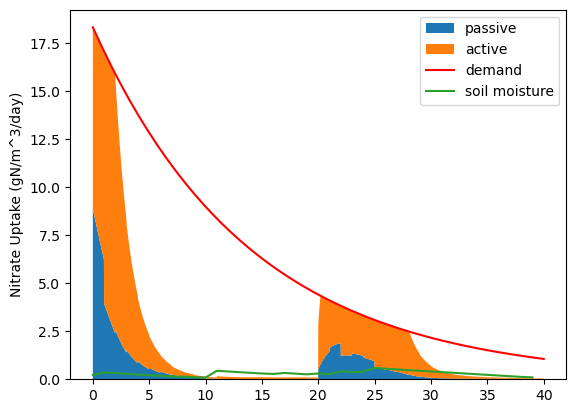

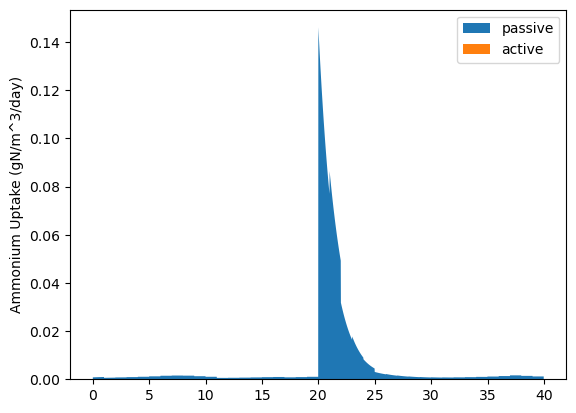

In [45]:
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate_passive_uptake, nitrate_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)), color="red", label="demand")
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture") #TODO needs a different scale
plt.legend(loc="upper right")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(ammonium_active_uptake)) * INORGANIC_N_MODEL_DT_DAYS, ammonium_passive_uptake, ammonium_active_uptake, labels=["passive", "active"])
# plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.legend(loc="upper right")

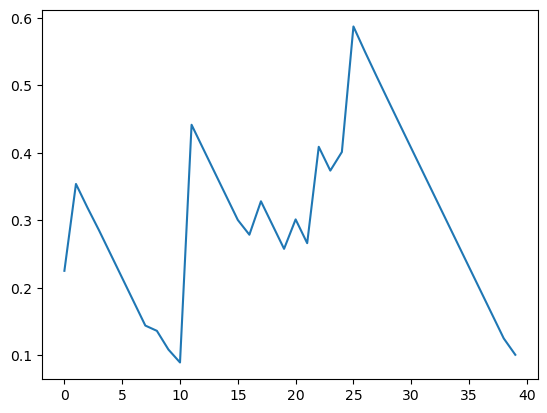

In [46]:
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture")

0.4666666666666667
1.0
1.029280263063063
1.0


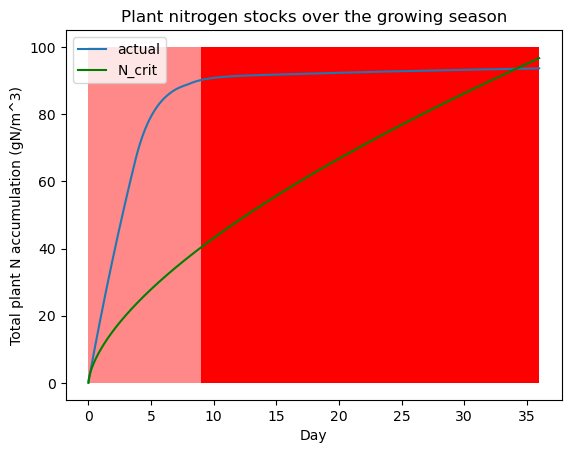

In [55]:
total_uptake = np.cumsum((ammonium_passive_uptake + nitrate_passive_uptake + ammonium_active_uptake + nitrate_active_uptake) * INORGANIC_N_MODEL_DT_DAYS)
fig, ax = plt.subplots()
ax.set_title("Plant nitrogen stocks over the growing season")
x_series = np.arange(len(total_uptake)) * INORGANIC_N_MODEL_DT_DAYS
ax.plot(x_series, total_uptake, label="actual")
ax.set_ylabel("Total plant N accumulation (gN/m^3)")
ax.set_xlabel("Day")
ax.plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit", color='g')
for i in range(NUM_CONTROL_STEPS):
    day = i * CONTROL_TIMESTEP_DAYS
    inorganic_n_model_idx = int(day / INORGANIC_N_MODEL_DT_DAYS)
    probability_of_violation = high_fine_probabilities_of_violation[i, accumulated_N_value_to_index(experiment_accumulated_N[inorganic_n_model_idx]), int(experiment_forecasts[i]), *values_to_indices(experiment_soil_moisture[day], ammonium[inorganic_n_model_idx], 60)]
    print(probability_of_violation)
    probability_of_violation = min(1.0, probability_of_violation)
    ax.fill([day, day, day + CONTROL_TIMESTEP_DAYS, day + CONTROL_TIMESTEP_DAYS], [0, 100, 100, 0], 'r', alpha=probability_of_violation)
ax.legend(loc="upper left")

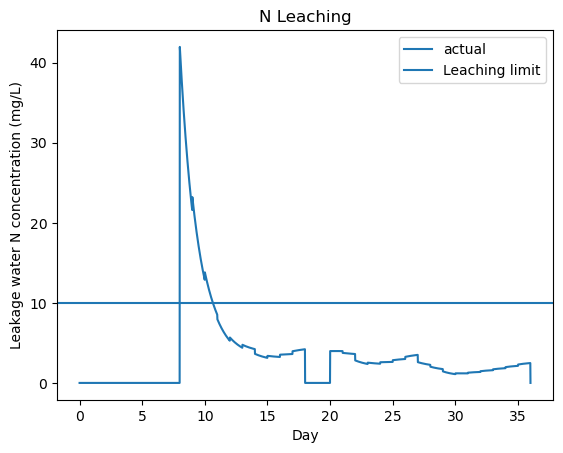

In [35]:
leaching_time_series = np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching))
leaching_concentration_gN_per_L = np.zeros(experiment_nitrate_leaching.shape)
for large_array_idx in range(len(leaching_time_series) - 1):
    small_array_idx = int(leaching_time_series[large_array_idx])
    if experiment_leakage_mm_per_day[small_array_idx] > 0:
        leaching_concentration_gN_per_L[large_array_idx] = (experiment_nitrate_leaching[large_array_idx] + experiment_ammonium_leaching[large_array_idx]) / experiment_leakage_mm_per_day[small_array_idx]
plt.figure()
plt.title("N Leaching")
plt.plot(leaching_time_series, leaching_concentration_gN_per_L * 1000, label="actual")
plt.axhline(y=LEACHING_CONCENTRATION_LIMIT_MG_PER_LITER, label="Leaching limit")
plt.xlabel("Day")
plt.ylabel("Leakage water N concentration (mg/L)")
plt.legend(loc="upper right")
# plt.plot(range(40), experiment_leakage_mm_per_day)

In [49]:
# average_profit = 0
# probability_of_violation = 0
n_trials = 10
continuous_trial_moisture_idx = 4
continuous_trials_violation_locations = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.uint16)
continuous_trials_average_profits = np.zeros([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
continuous_trials_violation_probabilities = np.zeros([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
for ammonium_idx in range(AMMONIUM_NUM_STEPS):
    for nitrate_idx in range(NITRATE_NUM_STEPS):
        _, starting_moisture, starting_ammonium, starting_nitrate = indices_to_values(0, continuous_trial_moisture_idx, ammonium_idx, nitrate_idx)
        for i in range(n_trials):
            deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N, experiment_leaching_limit_violated, experiment_per_step_leaching_limit_violated, experiment_forecasts = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, starting_moisture, starting_ammonium, starting_nitrate, generate_figures=False)
            revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
            expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
            profit = revenue - expenditures
            if experiment_leaching_limit_violated:
                profit -= LEACHING_VIOLATION_PENALTY_USD_PER_M2
                continuous_trials_violation_probabilities[ammonium_idx, nitrate_idx] += 1
                violating_step = np.where(experiment_per_step_leaching_limit_violated == 1)[0][0]
                if ammonium_idx == 0 and nitrate_idx == 0:
                    continuous_trials_violation_locations[int(experiment_forecasts[violating_step]), *values_to_indices(experiment_soil_moisture[violating_step * CONTROL_TIMESTEP_DAYS], ammonium[int(violating_step * CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)], nitrate[int(violating_step * CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)])] += 1
            continuous_trials_average_profits[ammonium_idx, nitrate_idx] += profit
continuous_trials_average_profits /= n_trials
continuous_trials_violation_probabilities /= n_trials
print("Probability of violation: {}\nAverage profit: {}".format(continuous_trials_violation_probabilities[0,0], continuous_trials_average_profits[0,0]))

Probability of violation: 0.366
Average profit: 0.12923136521857367


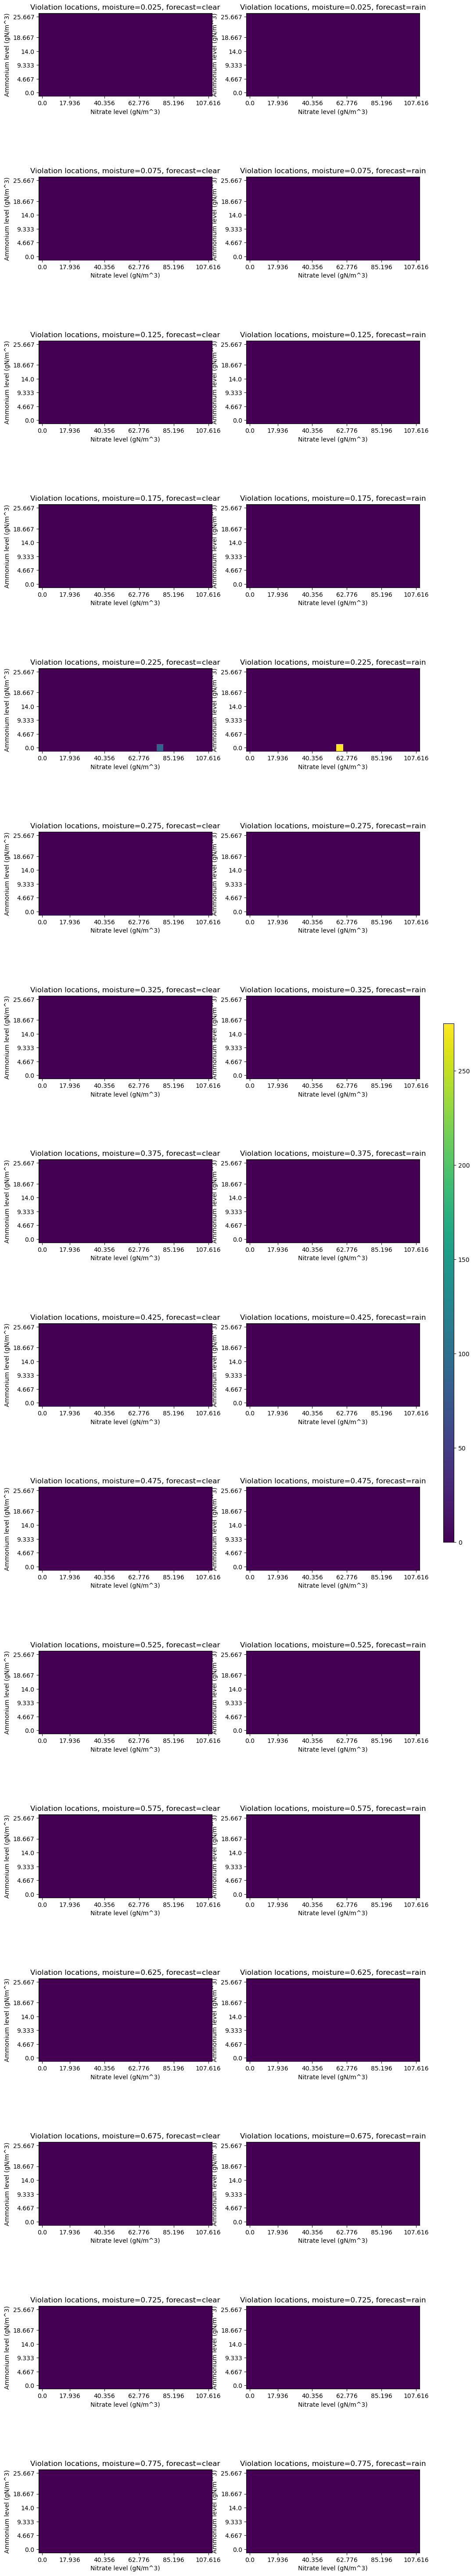

In [50]:
fig, axs = plt.subplots(MOISTURE_NUM_STEPS, 2, figsize=[7*2, 4.8 * MOISTURE_NUM_STEPS])
for moisture_index in range(MOISTURE_NUM_STEPS):
    for forecast in range(2):
        scalar_mappable = display_moisture_slice(continuous_trials_violation_locations[forecast, moisture_index], "Violation locations, moisture="+moisture_idx_to_string(moisture_index)+ ", forecast=" + ("clear" if forecast == 0 else "rain"), fig=fig, ax=axs[moisture_index, forecast], colorbar=False, vmin=0, vmax=np.max(continuous_trials_violation_locations))
fig.colorbar(scalar_mappable, ax=axs, aspect=50, shrink=0.2)

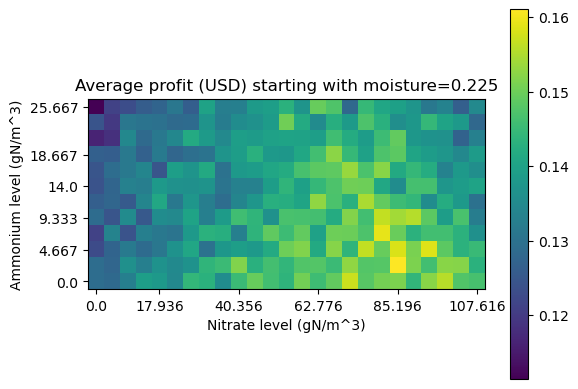

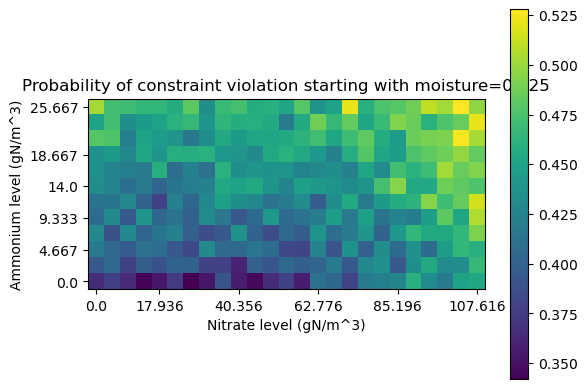

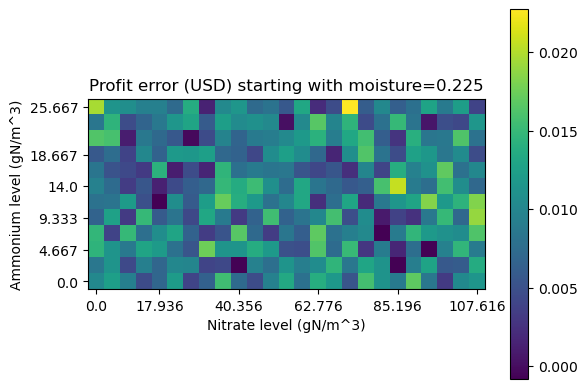

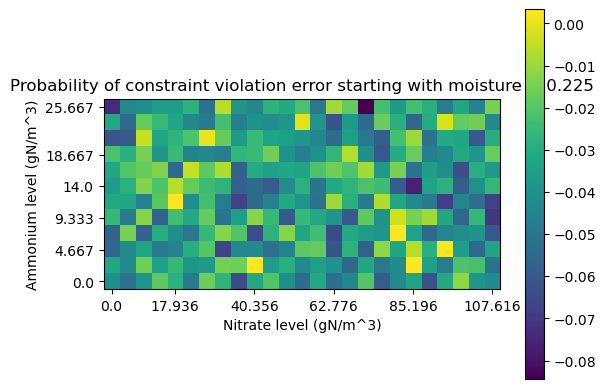

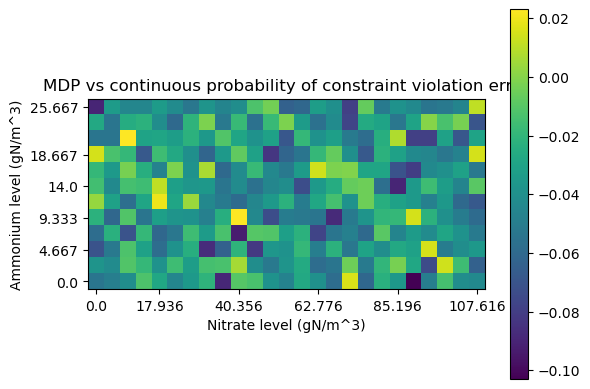

In [51]:
display_moisture_slice(continuous_trials_average_profits, "Average profit (USD) starting with moisture=" + moisture_idx_to_string(continuous_trial_moisture_idx))
display_moisture_slice(continuous_trials_violation_probabilities, "Probability of constraint violation starting with moisture=" + moisture_idx_to_string(continuous_trial_moisture_idx))
display_moisture_slice(N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - (optimal_cost_to_go_USD_per_m2[0, 0, 0, 0, continuous_trial_moisture_idx] * PROBABILITY_OF_CLEAR_FORECAST + optimal_cost_to_go_USD_per_m2[0, 0, 0, 1, continuous_trial_moisture_idx] * (1 - PROBABILITY_OF_CLEAR_FORECAST)) - continuous_trials_average_profits, "Profit error (USD) starting with moisture="+ moisture_idx_to_string(continuous_trial_moisture_idx))
display_moisture_slice((probabilities_of_violation[0, 0, 0, continuous_trial_moisture_idx] * PROBABILITY_OF_CLEAR_FORECAST + probabilities_of_violation[0, 0, 1, 4] * (1 - PROBABILITY_OF_CLEAR_FORECAST)) - continuous_trials_violation_probabilities, "Probability of constraint violation error starting with moisture = " + moisture_idx_to_string(4))
display_moisture_slice(MDP_violation_probabilities - continuous_trials_violation_probabilities, "MDP vs continuous probability of constraint violation error")

In [52]:
def run_simulation_open_loop(control_period_days: int, num_control_periods: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, nitrate_adds: List[float], ammonium_adds: List[float], initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500):
    rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_ammonium_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_accumulated_N_gN_per_m3 = np.zeros(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0

    for i in range(num_control_periods):
        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        indices = values_to_indices(soil_moisture[i * control_period_days], ammonium_gN_per_m3, nitrate_gN_per_m3)
        accumulated_N_index = accumulated_N_value_to_index(accumulated_N_gN_per_m3)

        fig, axs = plt.subplots(1, 4, figsize=[6.4*4, 4.8])

        display_moisture_slice(optimal_ammonium_add_in_cells[i, accumulated_N_index, indices[0]] * AMMONIUM_GRID_SIZE, "Optimal ammonium add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0])
        display_moisture_slice(optimal_nitrate_add_in_cells[i, accumulated_N_index, indices[0]] * NITRATE_GRID_SIZE, "Optimal nitrate add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[1])
        display_moisture_slice(optimal_cost_to_go_USD_per_m2[i, accumulated_N_index, indices[0]], "Optimal cost to go for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2])
        axs[3].set_title("N accumulation progress")
        x_series = np.arange(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS)) * INORGANIC_N_MODEL_DT_DAYS
        axs[3].plot(x_series[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], label="actual")
        axs[3].plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
        axs[3].set_ylabel("Total plant N accumulation (gN/m^3)")
        axs[3].set_xlabel("Day")
        axs[3].legend(loc="upper left")

        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], day_to_plant_N_demand_gN_per_m3_per_day, output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrate_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_leaching_gN_per_m3_per_day
        total_ammonium_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_leaching_gN_per_m3_per_day

        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = np.cumsum(combined_N_uptake * INORGANIC_N_MODEL_DT_DAYS) + accumulated_N_gN_per_m3
        total_nitrogen_deficit_cost += nitrogen_deficit_cost(total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], float(start_day), INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = total_plant_accumulated_N_gN_per_m3[int(end_day / INORGANIC_N_MODEL_DT_DAYS) - 1]

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]

    return total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, total_ammonium_leaching_gN_per_m3_per_day, total_nitrate_leaching_gN_per_m3_per_day, total_plant_accumulated_N_gN_per_m3

TypeError: Invalid shape (2, 16, 12, 25) for image data

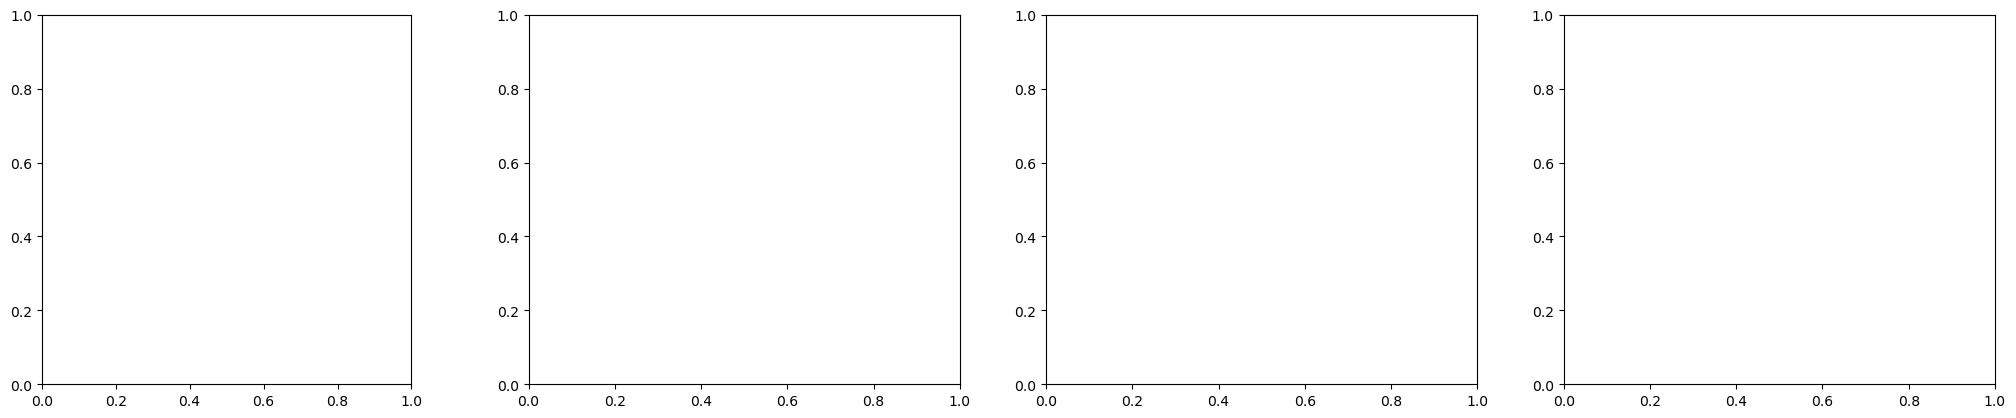

In [53]:
deficit_cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration, experiment_leakage_mm_per_day, experiment_ammonium_leaching, experiment_nitrate_leaching, experiment_accumulated_N = run_simulation_open_loop(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3, [5 / (SOIL_DEPTH_MM / 1000), 0, 0, 0], [25 / (SOIL_DEPTH_MM / 1000), 0, 0, 0])
revenue = N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN - deficit_cost
expenditures = (np.sum(added_ammonium) + np.sum(added_nitrate)) * (SOIL_DEPTH_MM / 1000.) * N_PRICE_USD_PER_G
print("Revenue: {}\nExpenditures: {}\nProfit: {}".format(revenue, expenditures, revenue - expenditures))

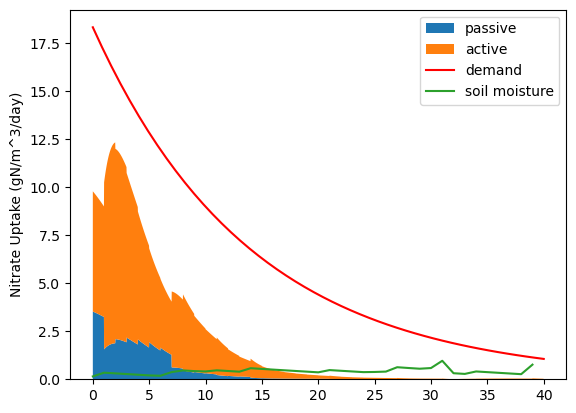

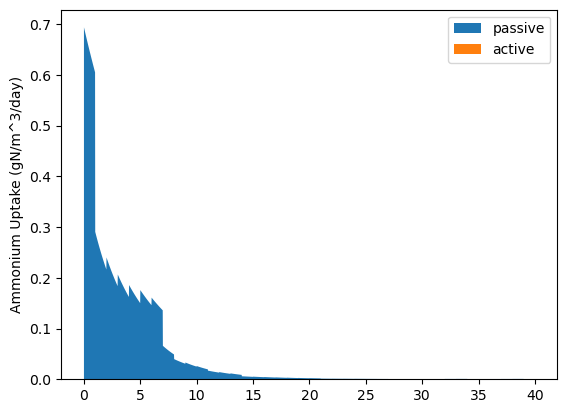

In [145]:
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate_passive_uptake, nitrate_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)), color="red", label="demand")
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture")
plt.legend(loc="upper right")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(ammonium_active_uptake)) * INORGANIC_N_MODEL_DT_DAYS, ammonium_passive_uptake, ammonium_active_uptake, labels=["passive", "active"])
# plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.legend(loc="upper right")

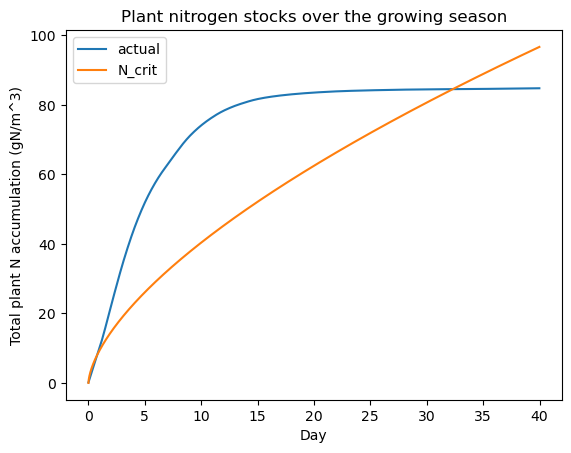

In [146]:
total_uptake = np.cumsum((ammonium_passive_uptake + nitrate_passive_uptake + ammonium_active_uptake + nitrate_active_uptake) * INORGANIC_N_MODEL_DT_DAYS)
plt.figure()
plt.title("Plant nitrogen stocks over the growing season")
x_series = np.arange(len(total_uptake)) * INORGANIC_N_MODEL_DT_DAYS
plt.plot(x_series, total_uptake, label="actual")
plt.ylabel("Total plant N accumulation (gN/m^3)")
plt.xlabel("Day")
plt.plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
plt.legend(loc="upper left")

Text(0, 0.5, 'Nitrate concentration (gN/m^3)')

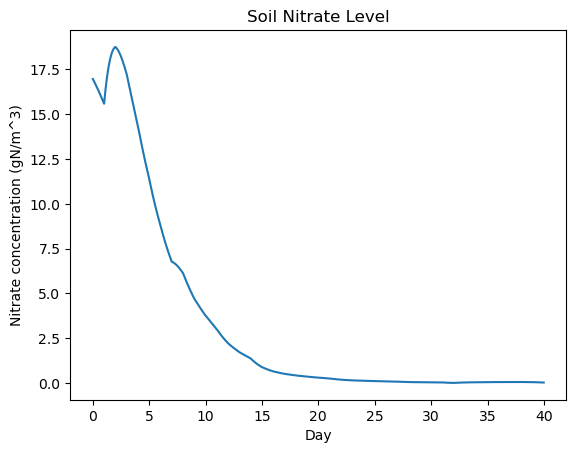

In [147]:
plt.plot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate)
plt.title("Soil Nitrate Level")
plt.xlabel("Day")
plt.ylabel("Nitrate concentration (gN/m^3)")

Text(0, 0.5, 'Ammonium concentration (gN/m^3)')

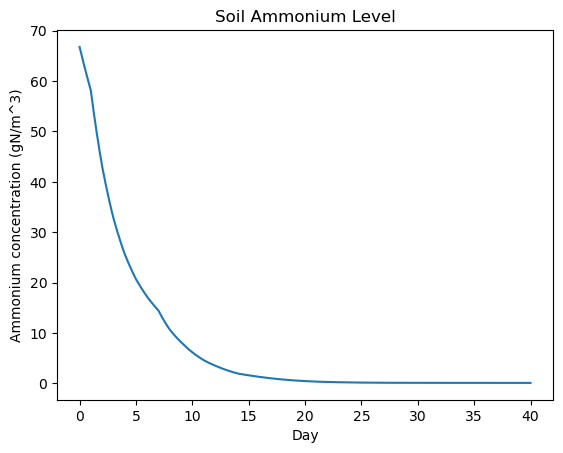

In [148]:
plt.plot(np.arange(len(ammonium)) * INORGANIC_N_MODEL_DT_DAYS, ammonium)
plt.title("Soil Ammonium Level")
plt.xlabel("Day")plt.figure()
plt.title("N Leaching")
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, len(experiment_ammonium_leaching)), experiment_ammonium_leaching, label="ammonium")
plt.plot(np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching)), experiment_nitrate_leaching, label="nitrate")
plt.xlabel("Day")
plt.ylabel("Leaching rate (gN/m^3/day)")
plt.legend(loc="upper right")
plt.ylabel("Ammonium concentration (gN/m^3)")

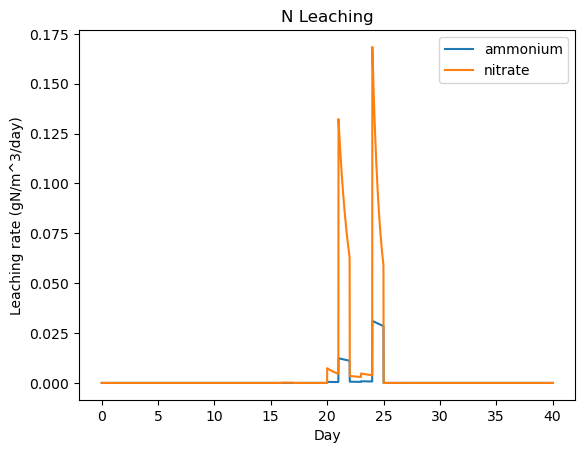

In [151]:
leaching_time_series = np.linspace(0, NUM_DAYS_TOTAL, len(experiment_nitrate_leaching))
leaching_concentration_gN_per_L = np.zeros(experiment_nitrate_leaching.shape)
for large_array_idx in range(len(leaching_time_series) - 1):
    small_array_idx = int(leaching_time_series[large_array_idx])
    if experiment_leakage_mm_per_day[small_array_idx] > 0:
        leaching_concentration_gN_per_L[large_array_idx] = (experiment_nitrate_leaching[large_array_idx] + experiment_ammonium_leaching[large_array_idx]) / experiment_leakage_mm_per_day[small_array_idx]
plt.figure()
plt.title("N Leaching")
plt.plot(leaching_time_series, leaching_concentration_gN_per_L * 1000)
plt.xlabel("Day")
plt.ylabel("Leakage water N concentration (mg/L)")

In [54]:
with open(str(CONTROL_TIMESTEP_DAYS) + '_transition_counts.pickle', 'wb') as f:
    pickle.dump(transition_counts, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_expected_plant_N_deficit.pickle', 'wb') as f:
    pickle.dump(expected_plant_N_deficit_cost_USD, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_optimal_cost_to_go_USD_per_m2.pickle', 'wb') as f:
    pickle.dump(optimal_cost_to_go_USD_per_m2, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_optimal_nitrate_add_in_cells.pickle', 'wb') as f:
    pickle.dump(optimal_nitrate_add_in_cells, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_optimal_ammonium_add_in_cells.pickle', 'wb') as f:
    pickle.dump(optimal_ammonium_add_in_cells, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_pareto_sweep_expected_profit.pickle', 'wb') as f:
    pickle.dump(pareto_sweep_expected_profit, f, pickle.HIGHEST_PROTOCOL)
with open(str(CONTROL_TIMESTEP_DAYS) + '_pareto_sweep_probability_of_violation.pickle', 'wb') as f:
    pickle.dump(pareto_sweep_probability_of_violation, f, pickle.HIGHEST_PROTOCOL)